# Construct accuracy curves

In [1]:
import sys
import copy
import random

sys.path.append("..")

from scripts.load_results import load_results
from strategic_ttc.verifiers.boxed_number import parse_pred_from_explanation
from scripts.accuracy_analysis import (
    plot_model_curves,
    plot_model_curves_with_tokens,
    plot_all_curves,
    plot_all_curves_delta,
    reasoning_accuracy_curve_second_custom,
    compute_curves_for_model_fast,
    plot_reasoning_curves_accuracy_and_tokens
)
import matplotlib.pyplot as plt
import numpy as np

from typing import List, Dict, Tuple, Any, Optional
from dataclasses import dataclass

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = load_results("../final_runs/GSM8K")
maj_mean, maj_std, rew_mean, rew_std = {}, {}, {}, {}
token_mean, token_std = {}, {}
thetas = {}

Processing file: Qwen2.5-7B--temp-0.7--samples-128--max-512.jsonl
Processing file: Qwen2.5-3B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-3B--temp-0.6--samples-128--max-512.jsonl
Processing file: Llama-3-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: reason-R1-D-Qwen-1.5B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Qwen2-1.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: Llama-3.2-1B--temp-0.6--samples-128--max-512.jsonl
Processing file: reason-R1-D-Qwen-7B--temp-0.6--samples-32--max-2048.jsonl
Processing file: reason-R1-D-Llama-8B--temp-0.6--samples-32--max-2048.jsonl
Processing file: Llama-3.1-8B--temp-0.6--samples-128--max-512.jsonl
Processing file: Qwen2-0.5B--temp-0.7--samples-128--max-512.jsonl
Processing file: Qwen2-7B--temp-0.7--samples-128--max-512.jsonl


In [3]:
reasoning_models = [
    "reason-R1-D-Llama-8B--temp-0.6",
    "reason-R1-D-Qwen-1.5B--temp-0.6",
    "reason-R1-D-Qwen-7B--temp-0.6",
]

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})


Processing model: Qwen2.5-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 40.51it/s]


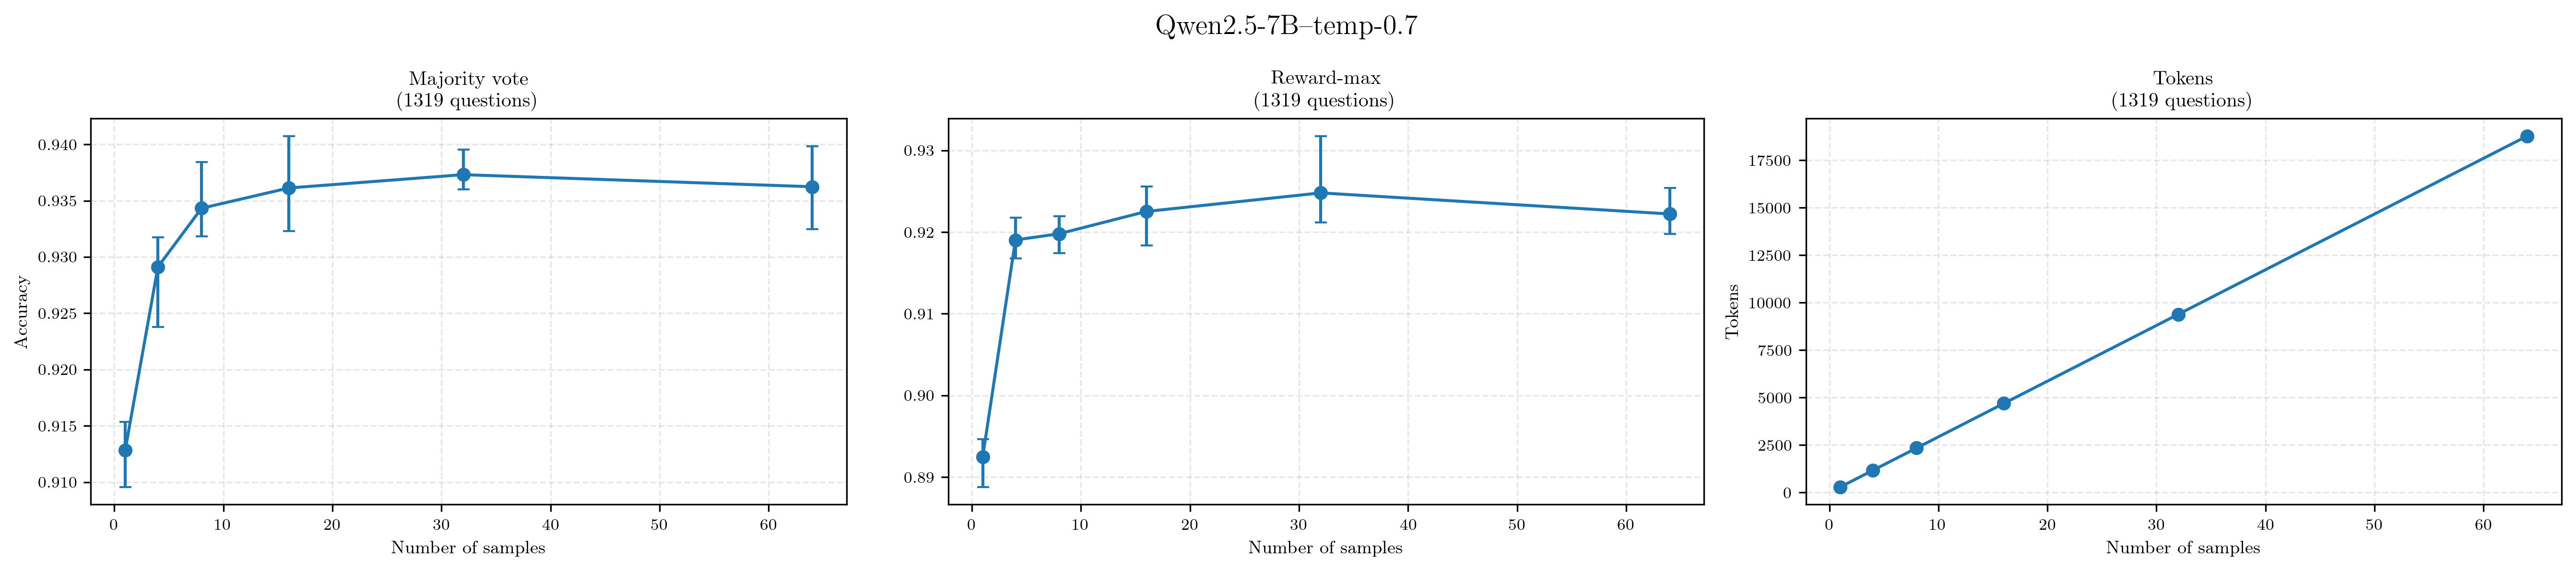

Processing model: Qwen2.5-3B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 43.80it/s]


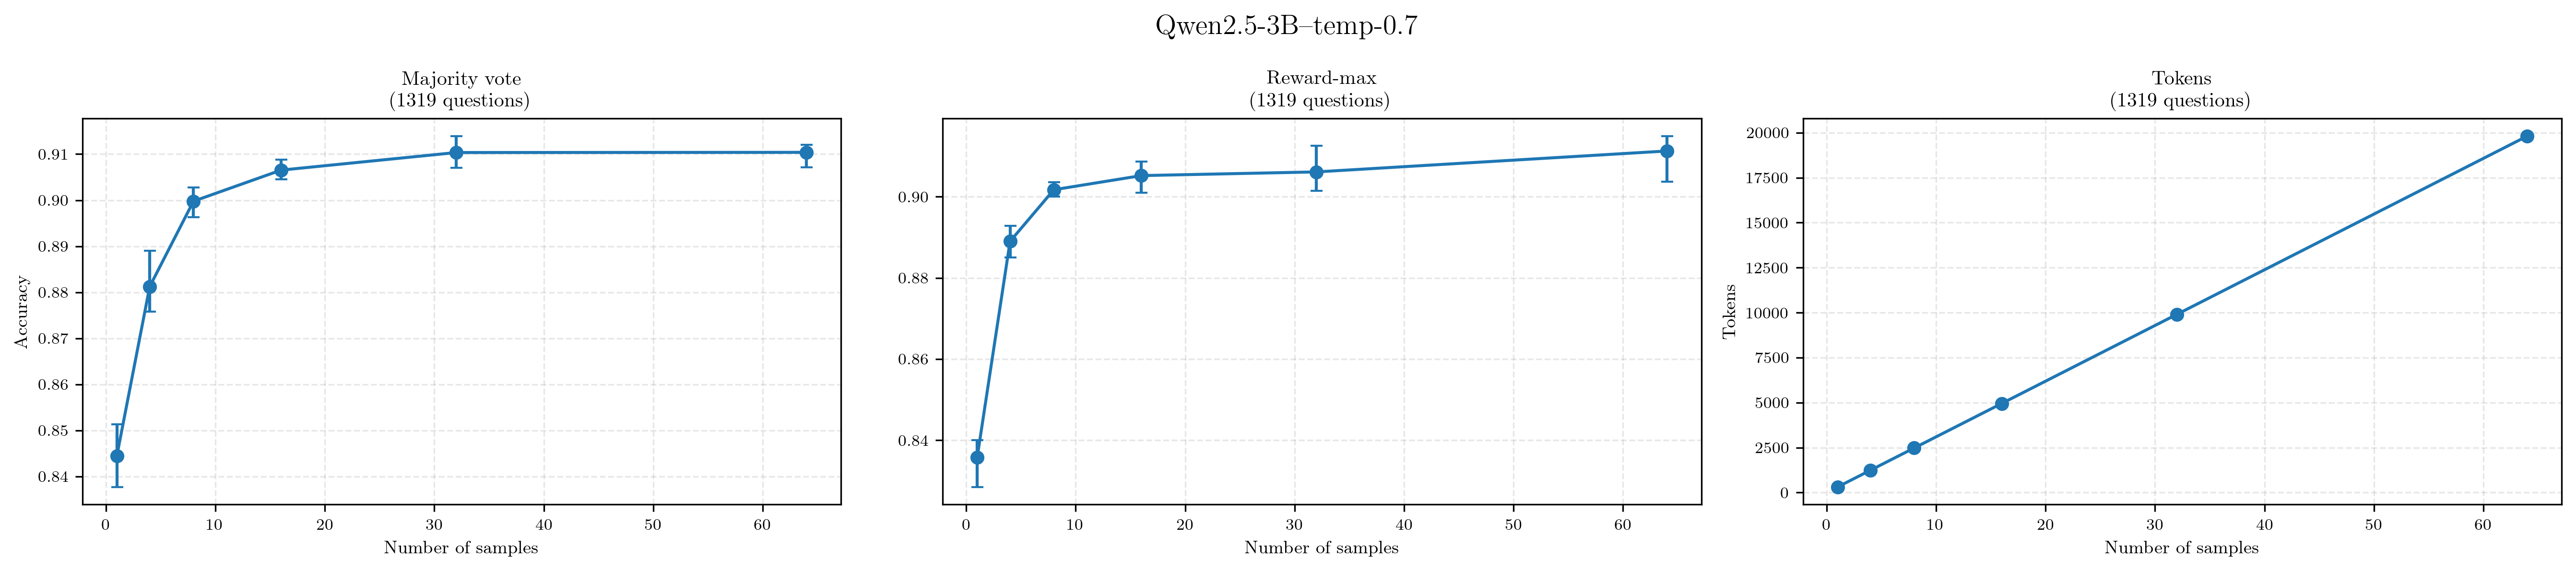

Processing model: Llama-3.2-3B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 44.34it/s]


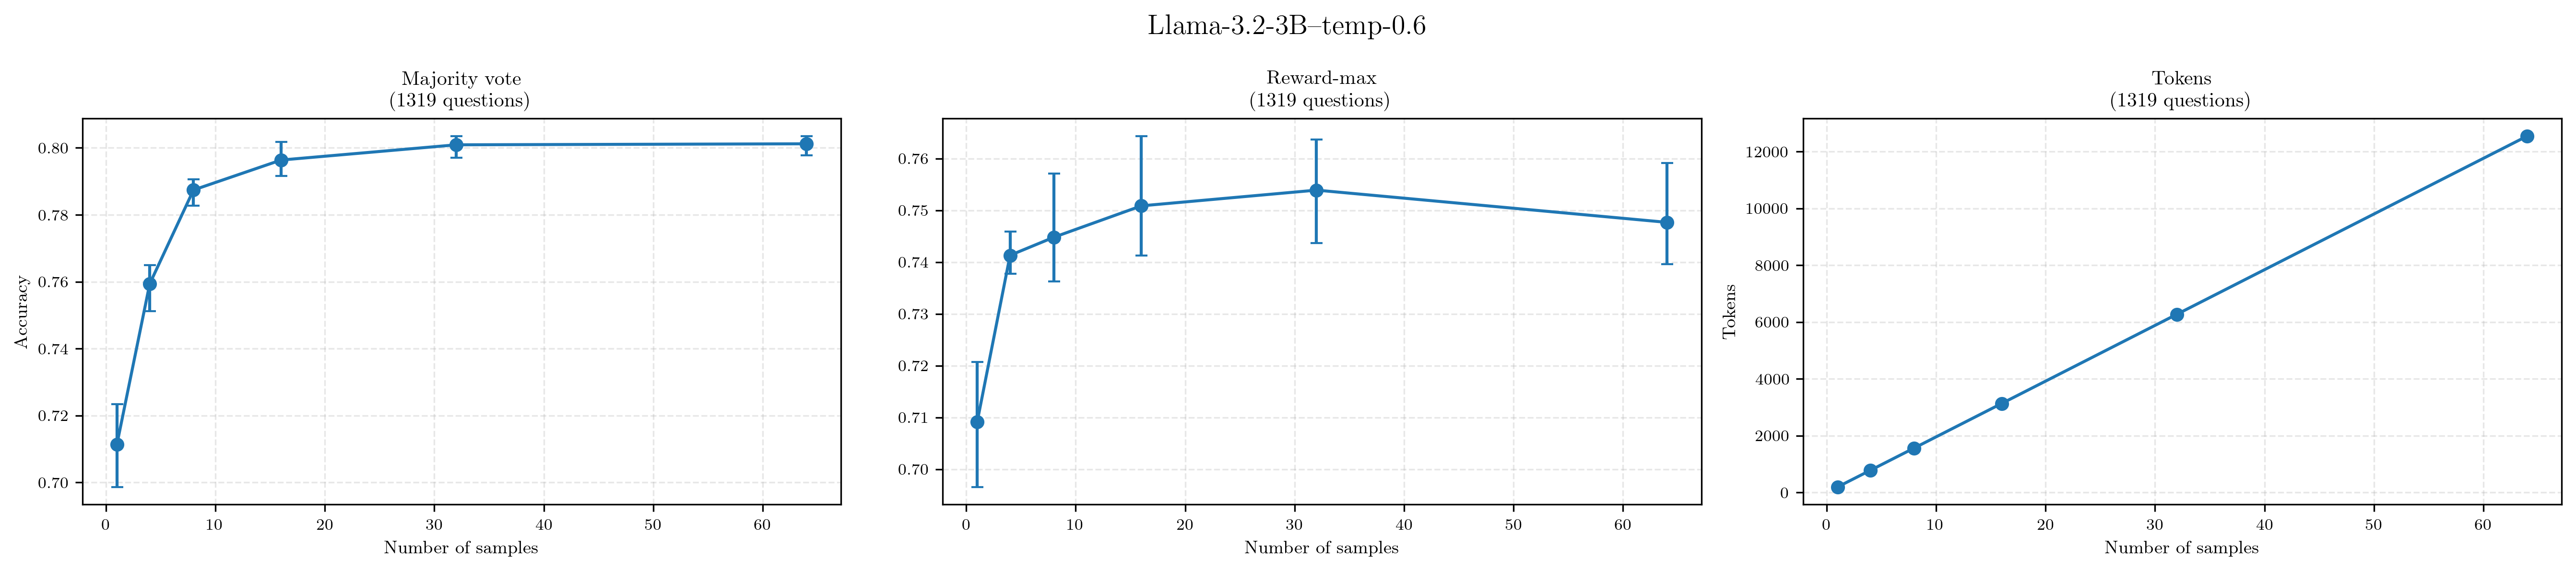

Processing model: Llama-3-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 43.99it/s]


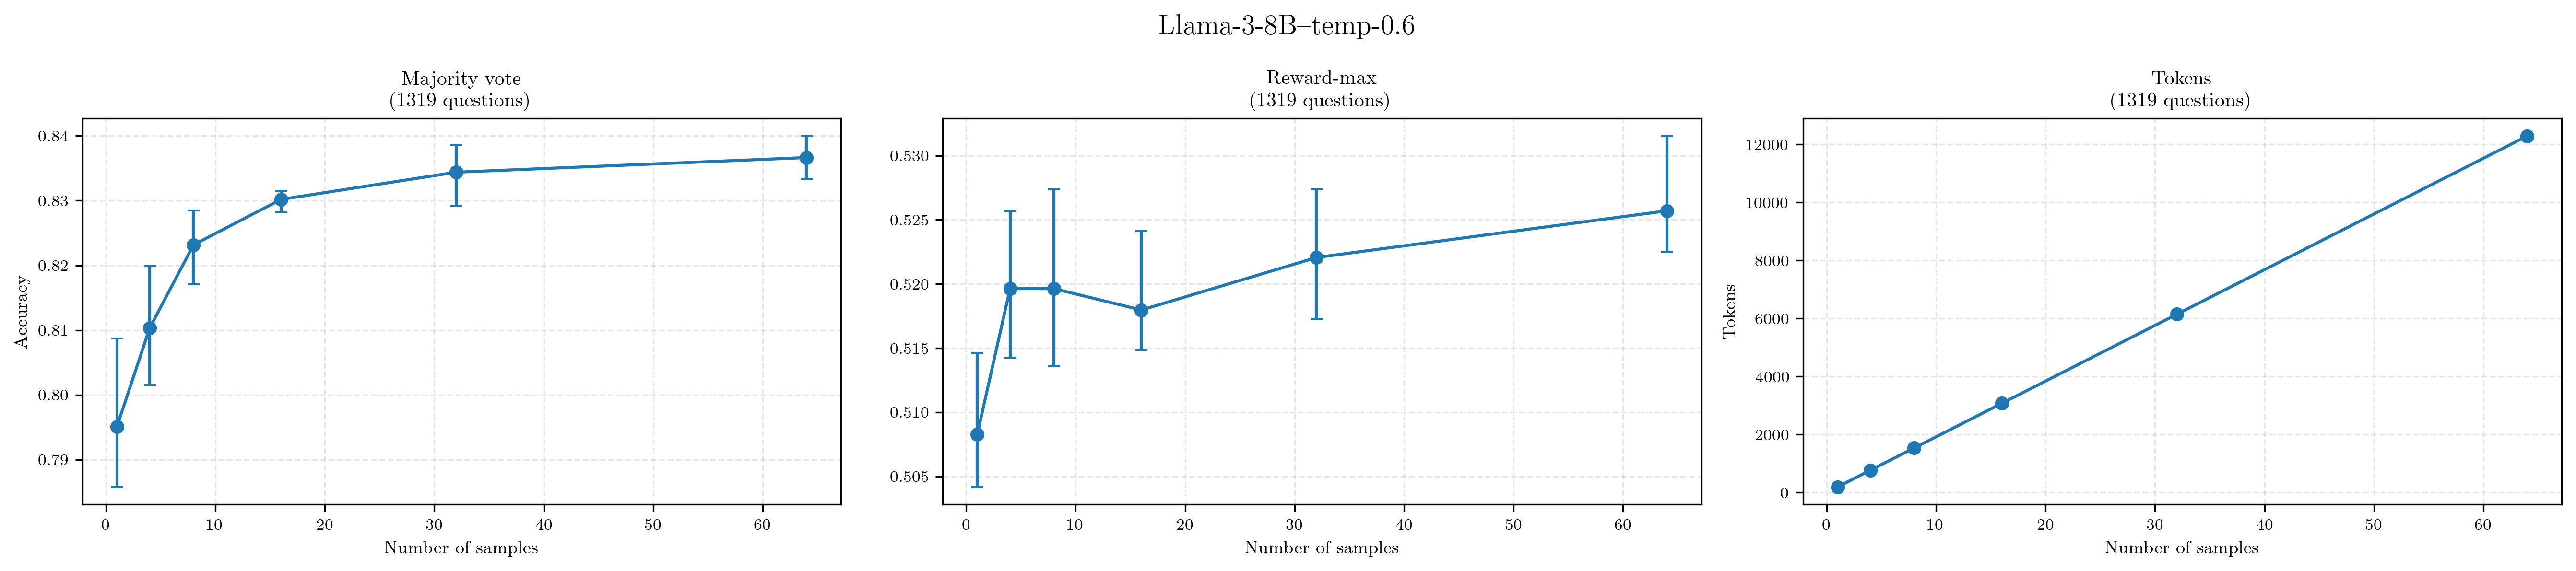

Processing model: Qwen2-1.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 43.24it/s]


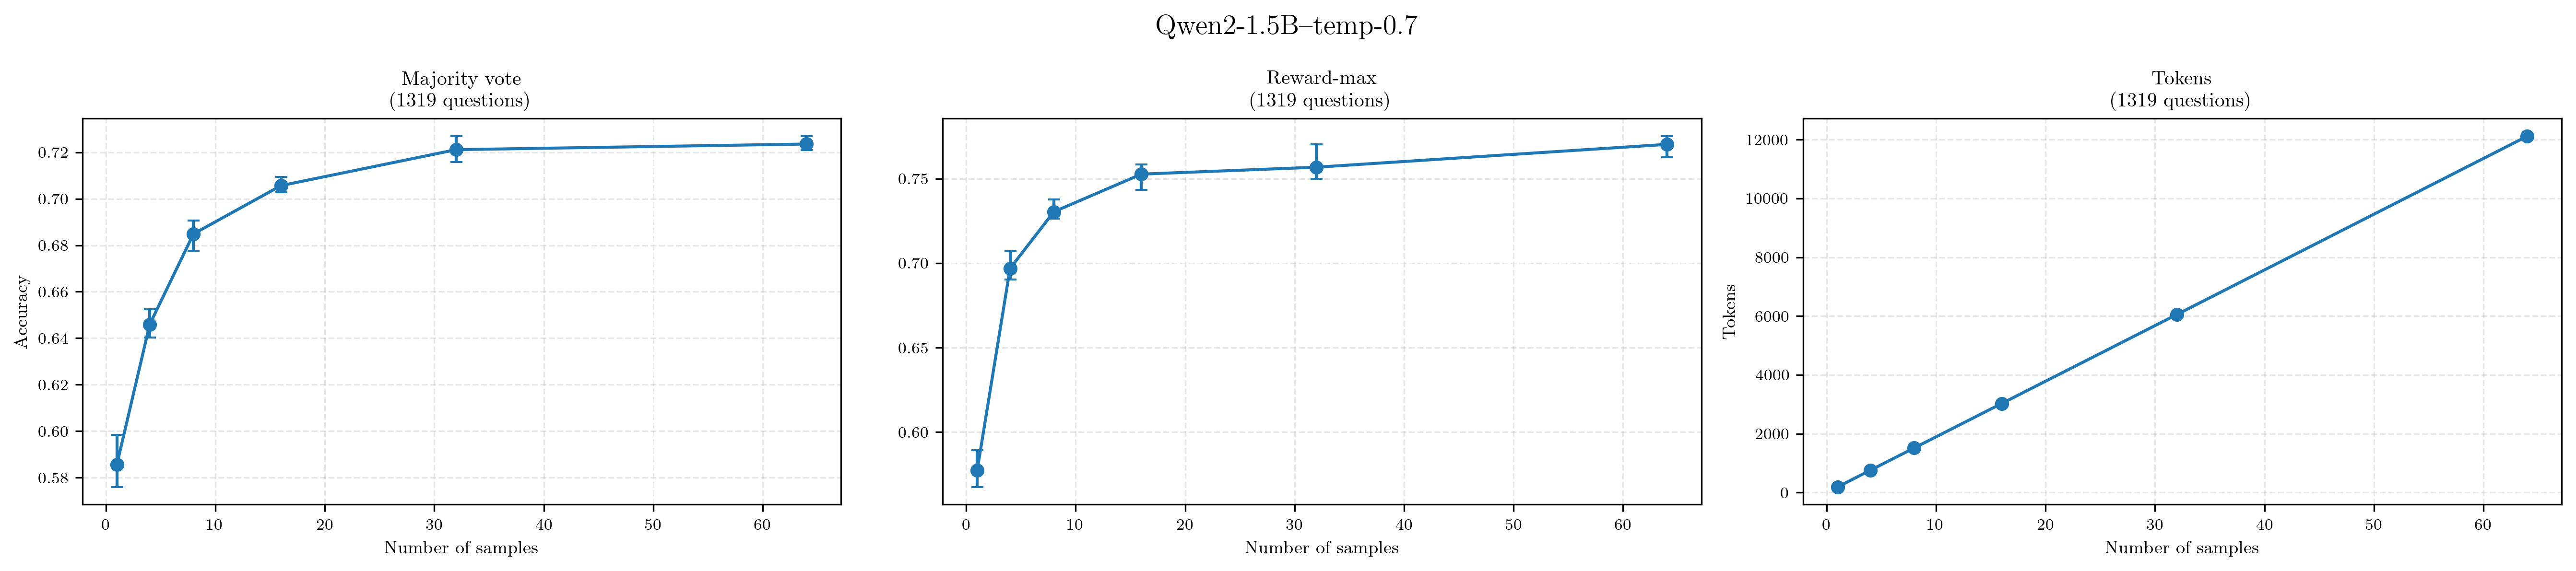

Processing model: Llama-3.2-1B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 43.98it/s]


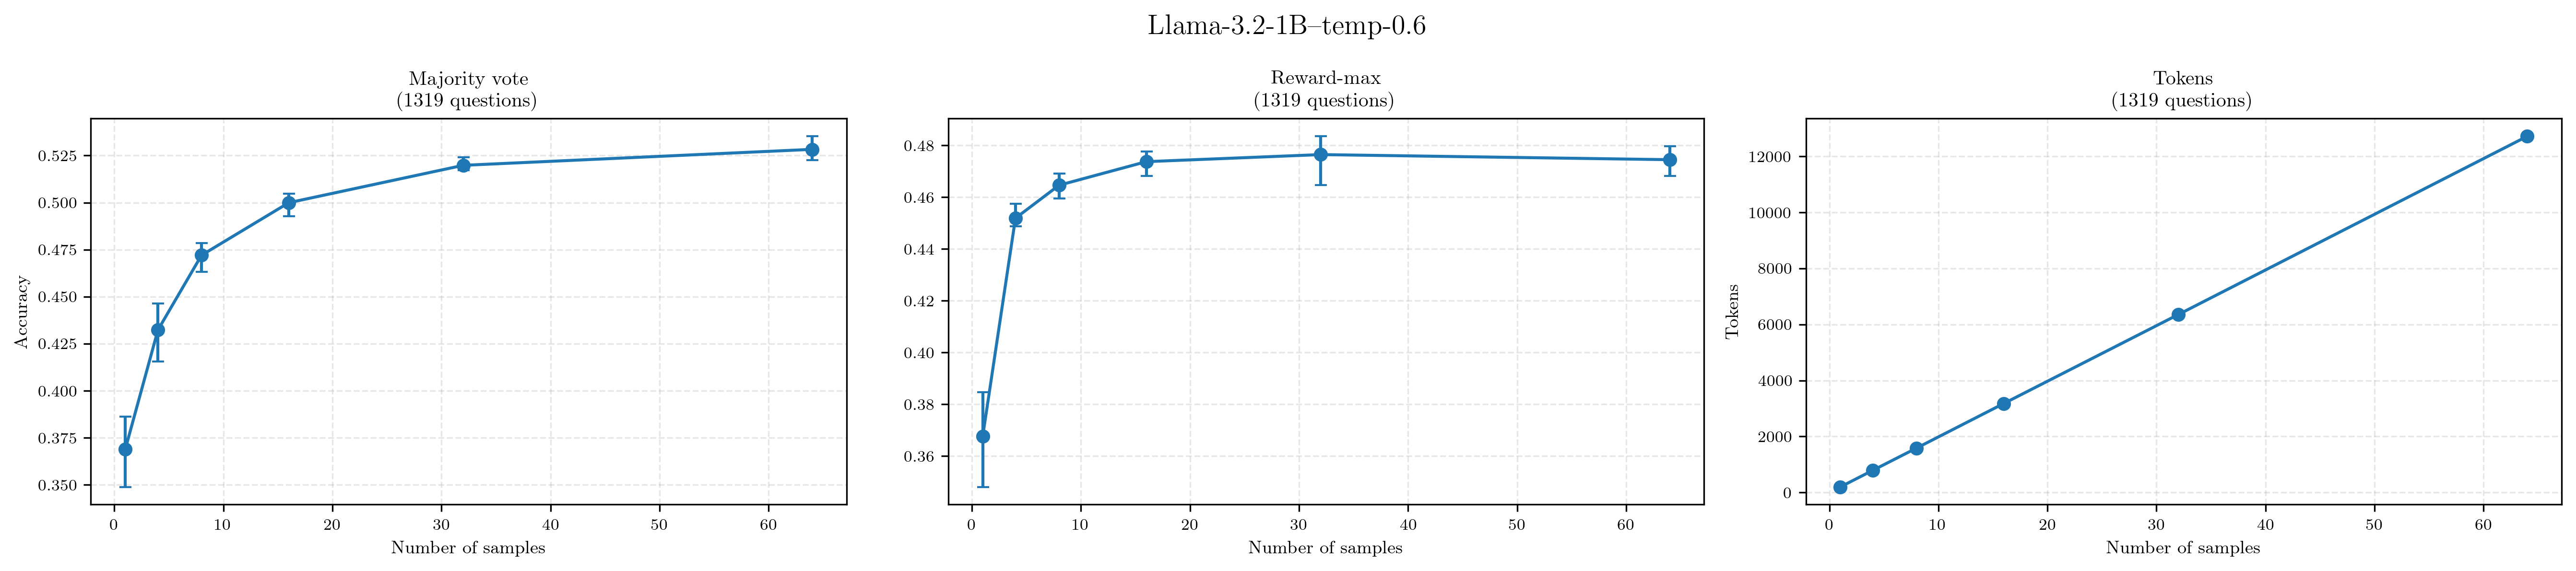

Processing model: Llama-3.1-8B--temp-0.6


100%|██████████| 6/6 [00:00<00:00, 45.53it/s]


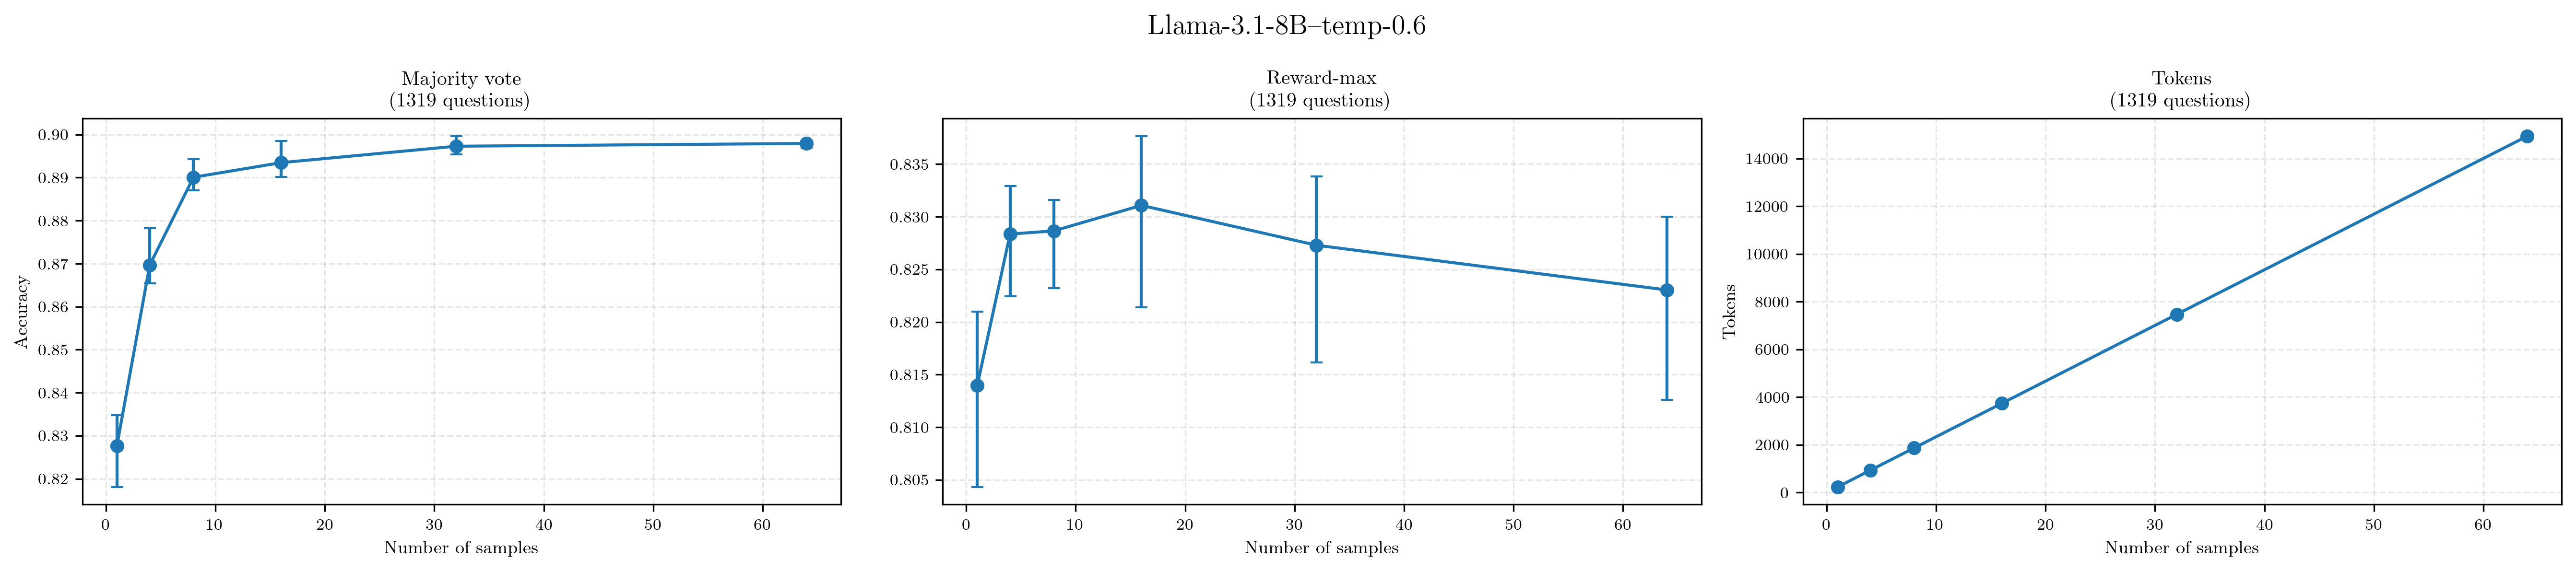

Processing model: Qwen2-0.5B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 44.97it/s]


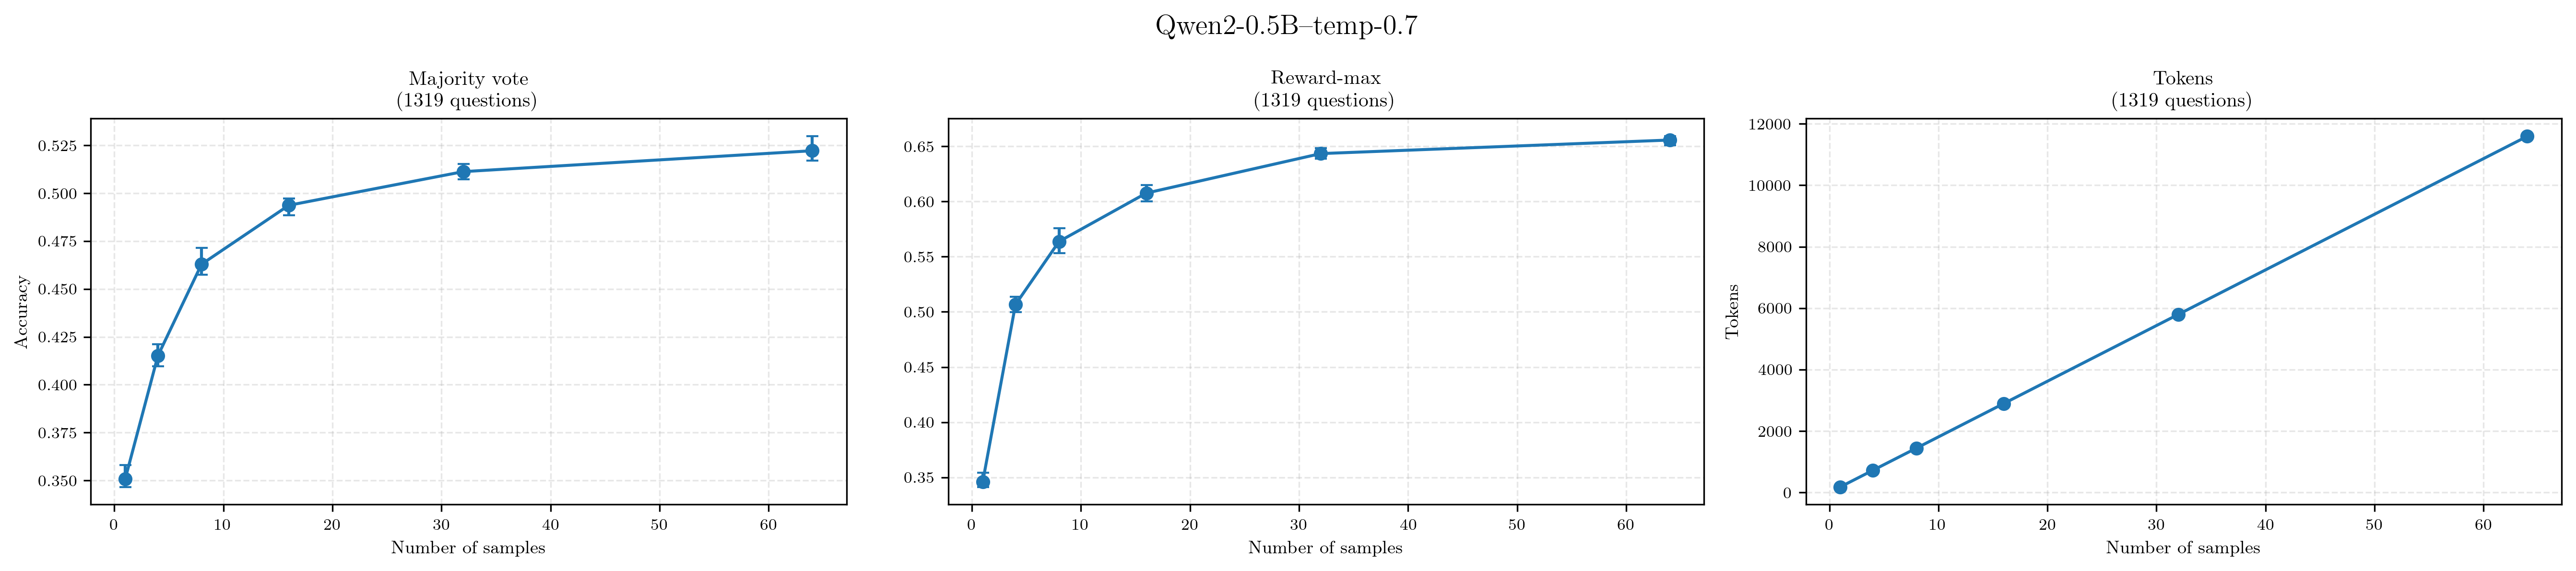

Processing model: Qwen2-7B--temp-0.7


100%|██████████| 6/6 [00:00<00:00, 43.56it/s]


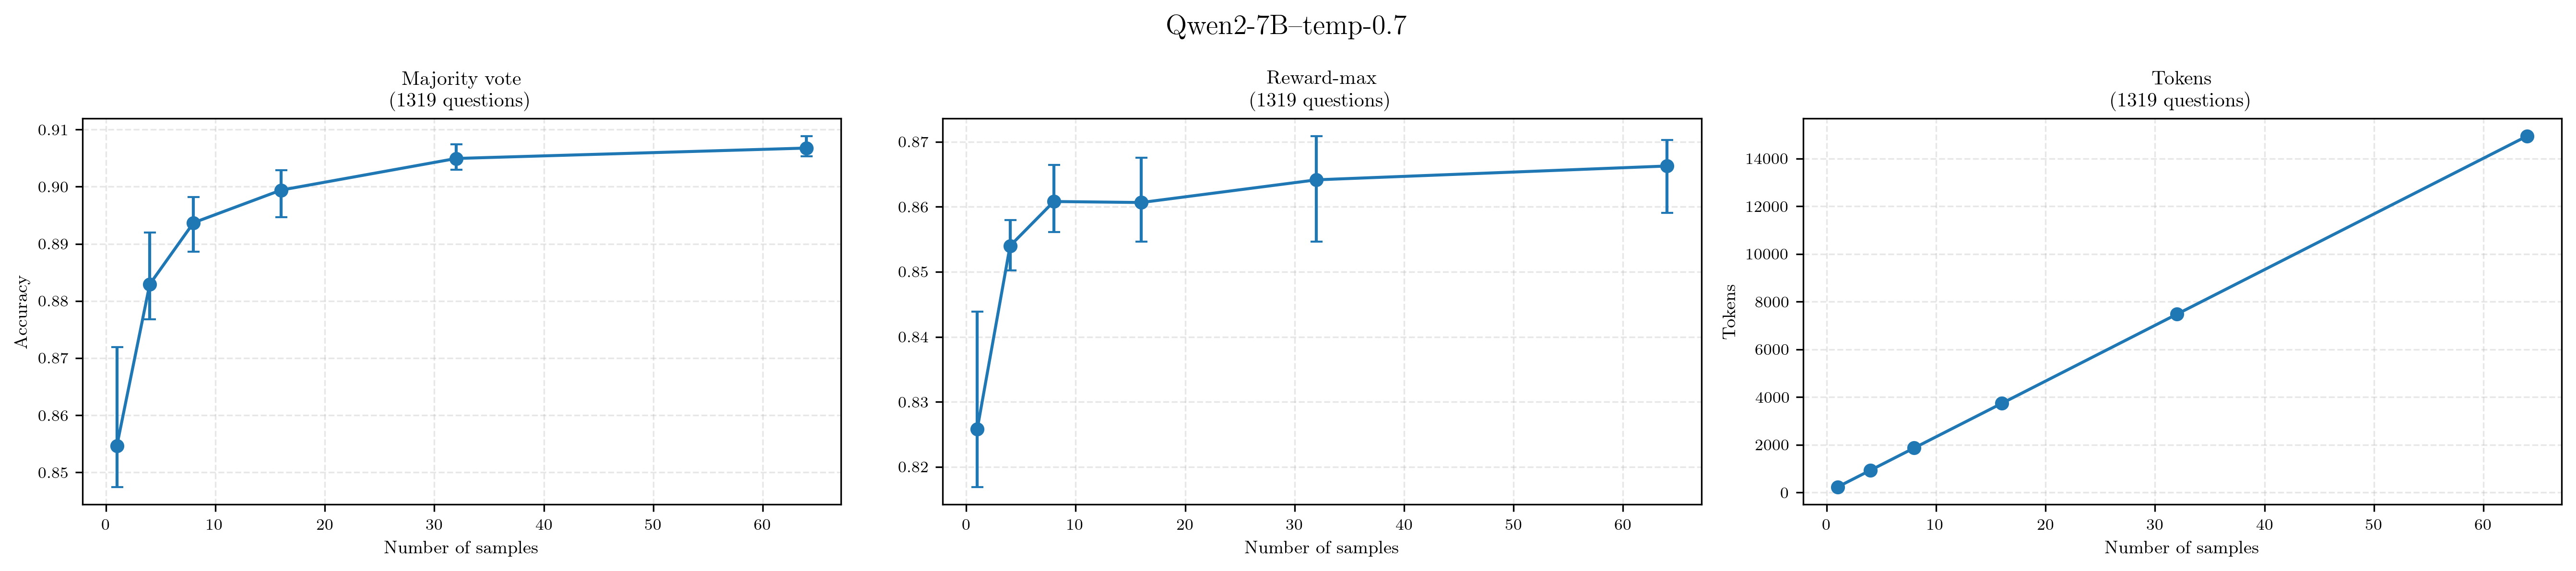

In [5]:
for model_name, data in results.items():
    if model_name in reasoning_models:
        continue
    print(f"Processing model: {model_name}")
    (
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        token_mean[model_name],
        token_std[model_name],
    ) = compute_curves_for_model_fast(
        data,
        parse_pred_fn=parse_pred_from_explanation,
        sample_size=5,
    )
    plot_model_curves_with_tokens(
        model_name,
        thetas[model_name],
        maj_mean[model_name],
        maj_std[model_name],
        rew_mean[model_name],
        rew_std[model_name],
        token_mean[model_name],
        token_std[model_name],
        len(data["correct"]),
    )

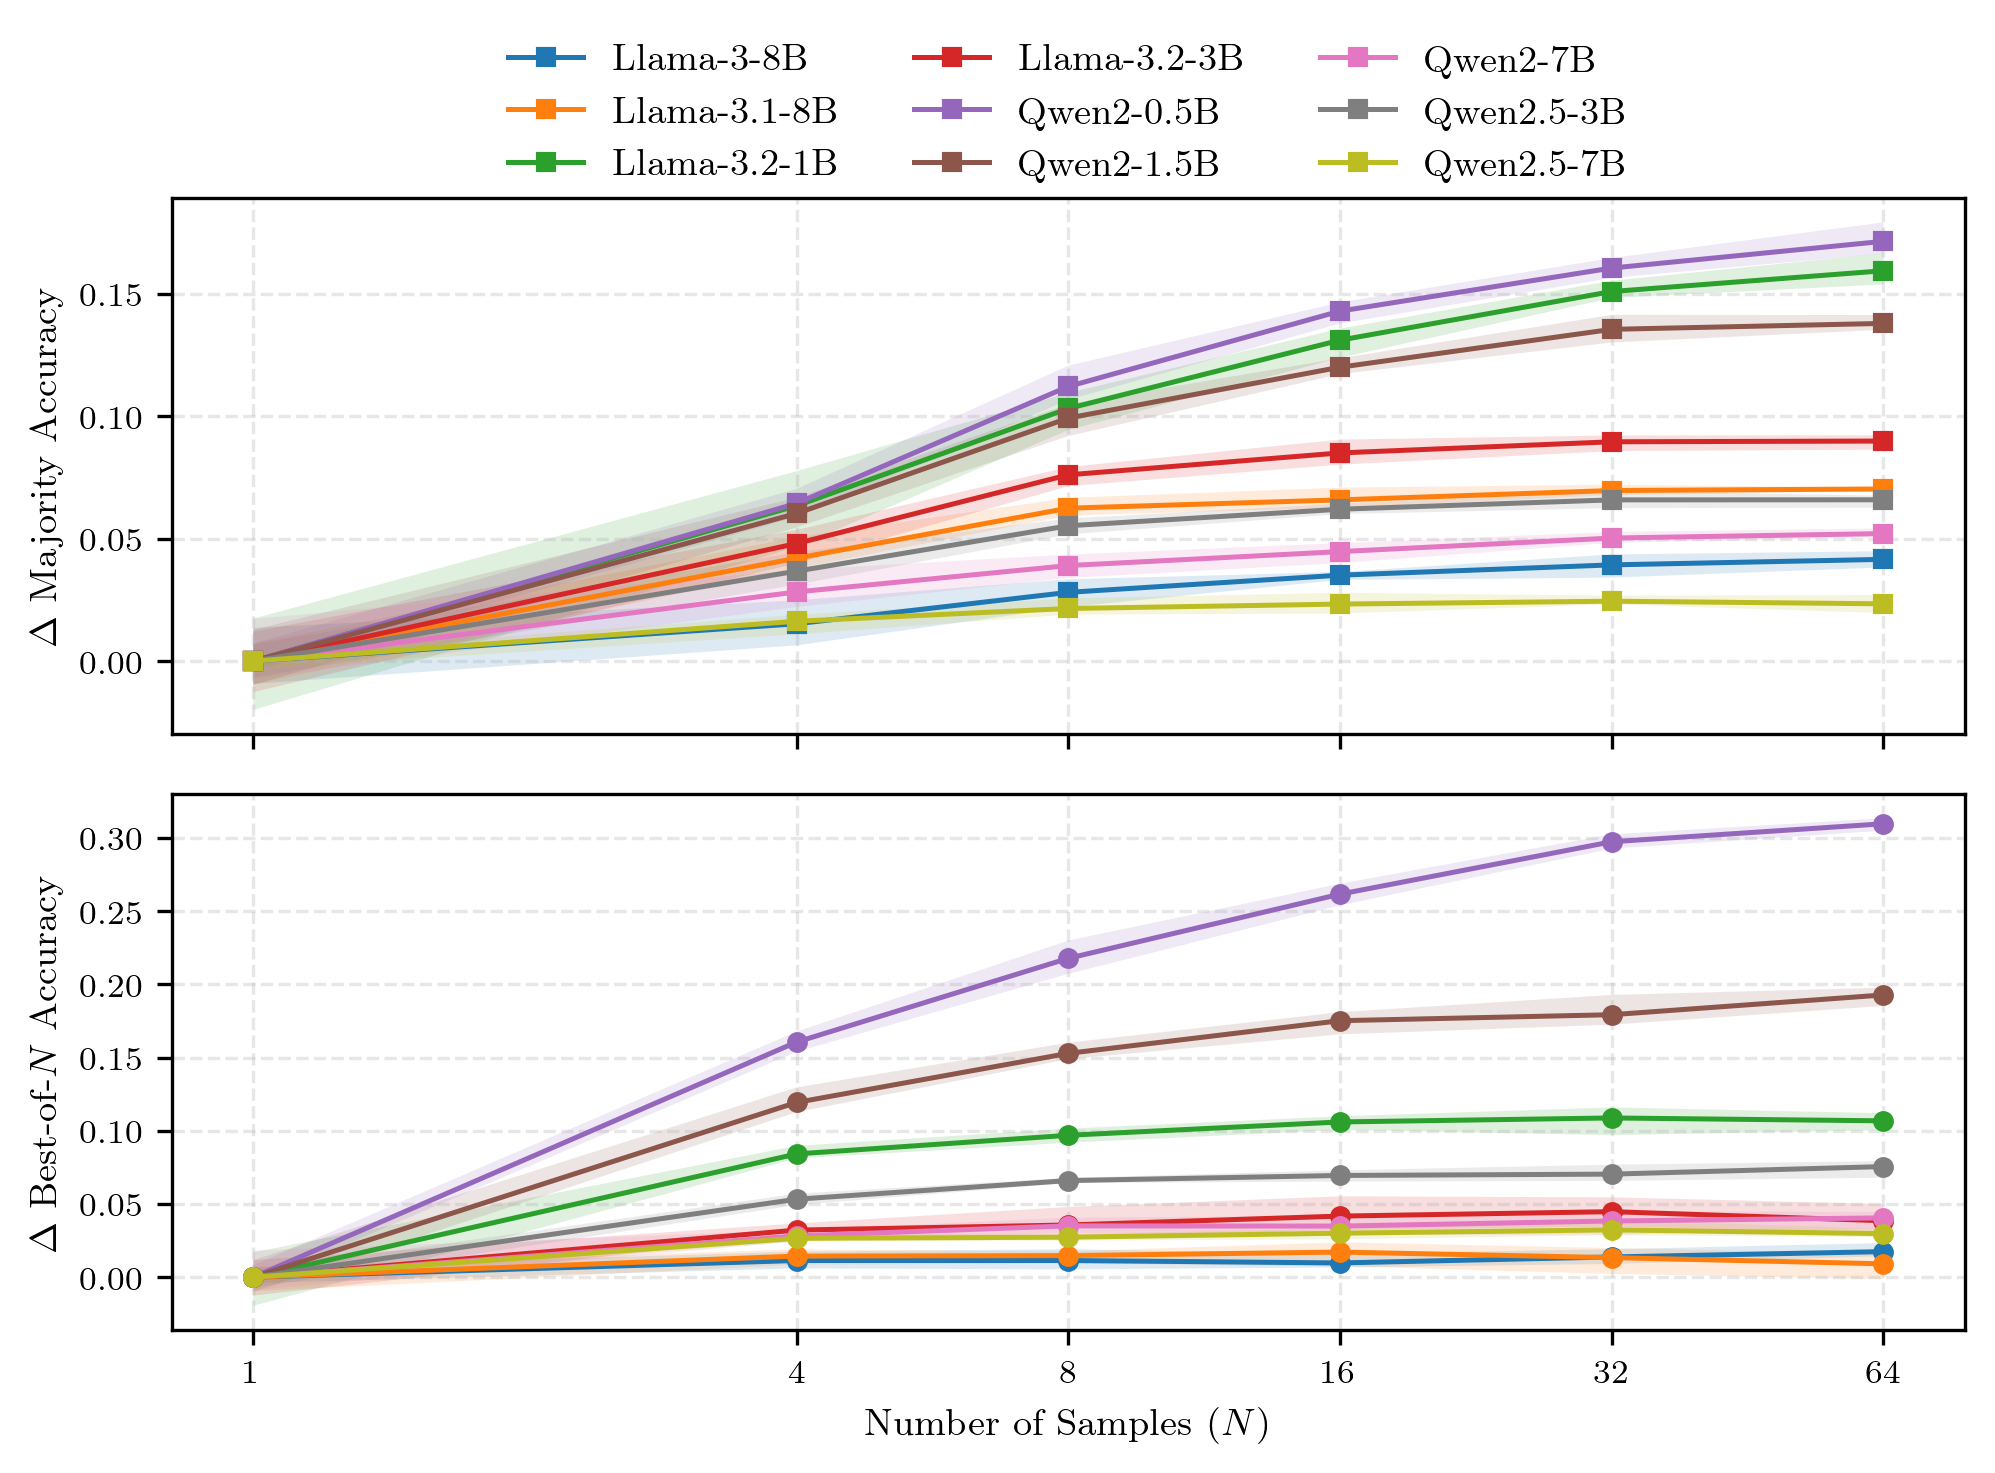

In [6]:
plot_all_curves_delta(
    thetas, maj_mean, maj_std, rew_mean, rew_std, filename="../figures/GSM8K/curves.pdf"
)

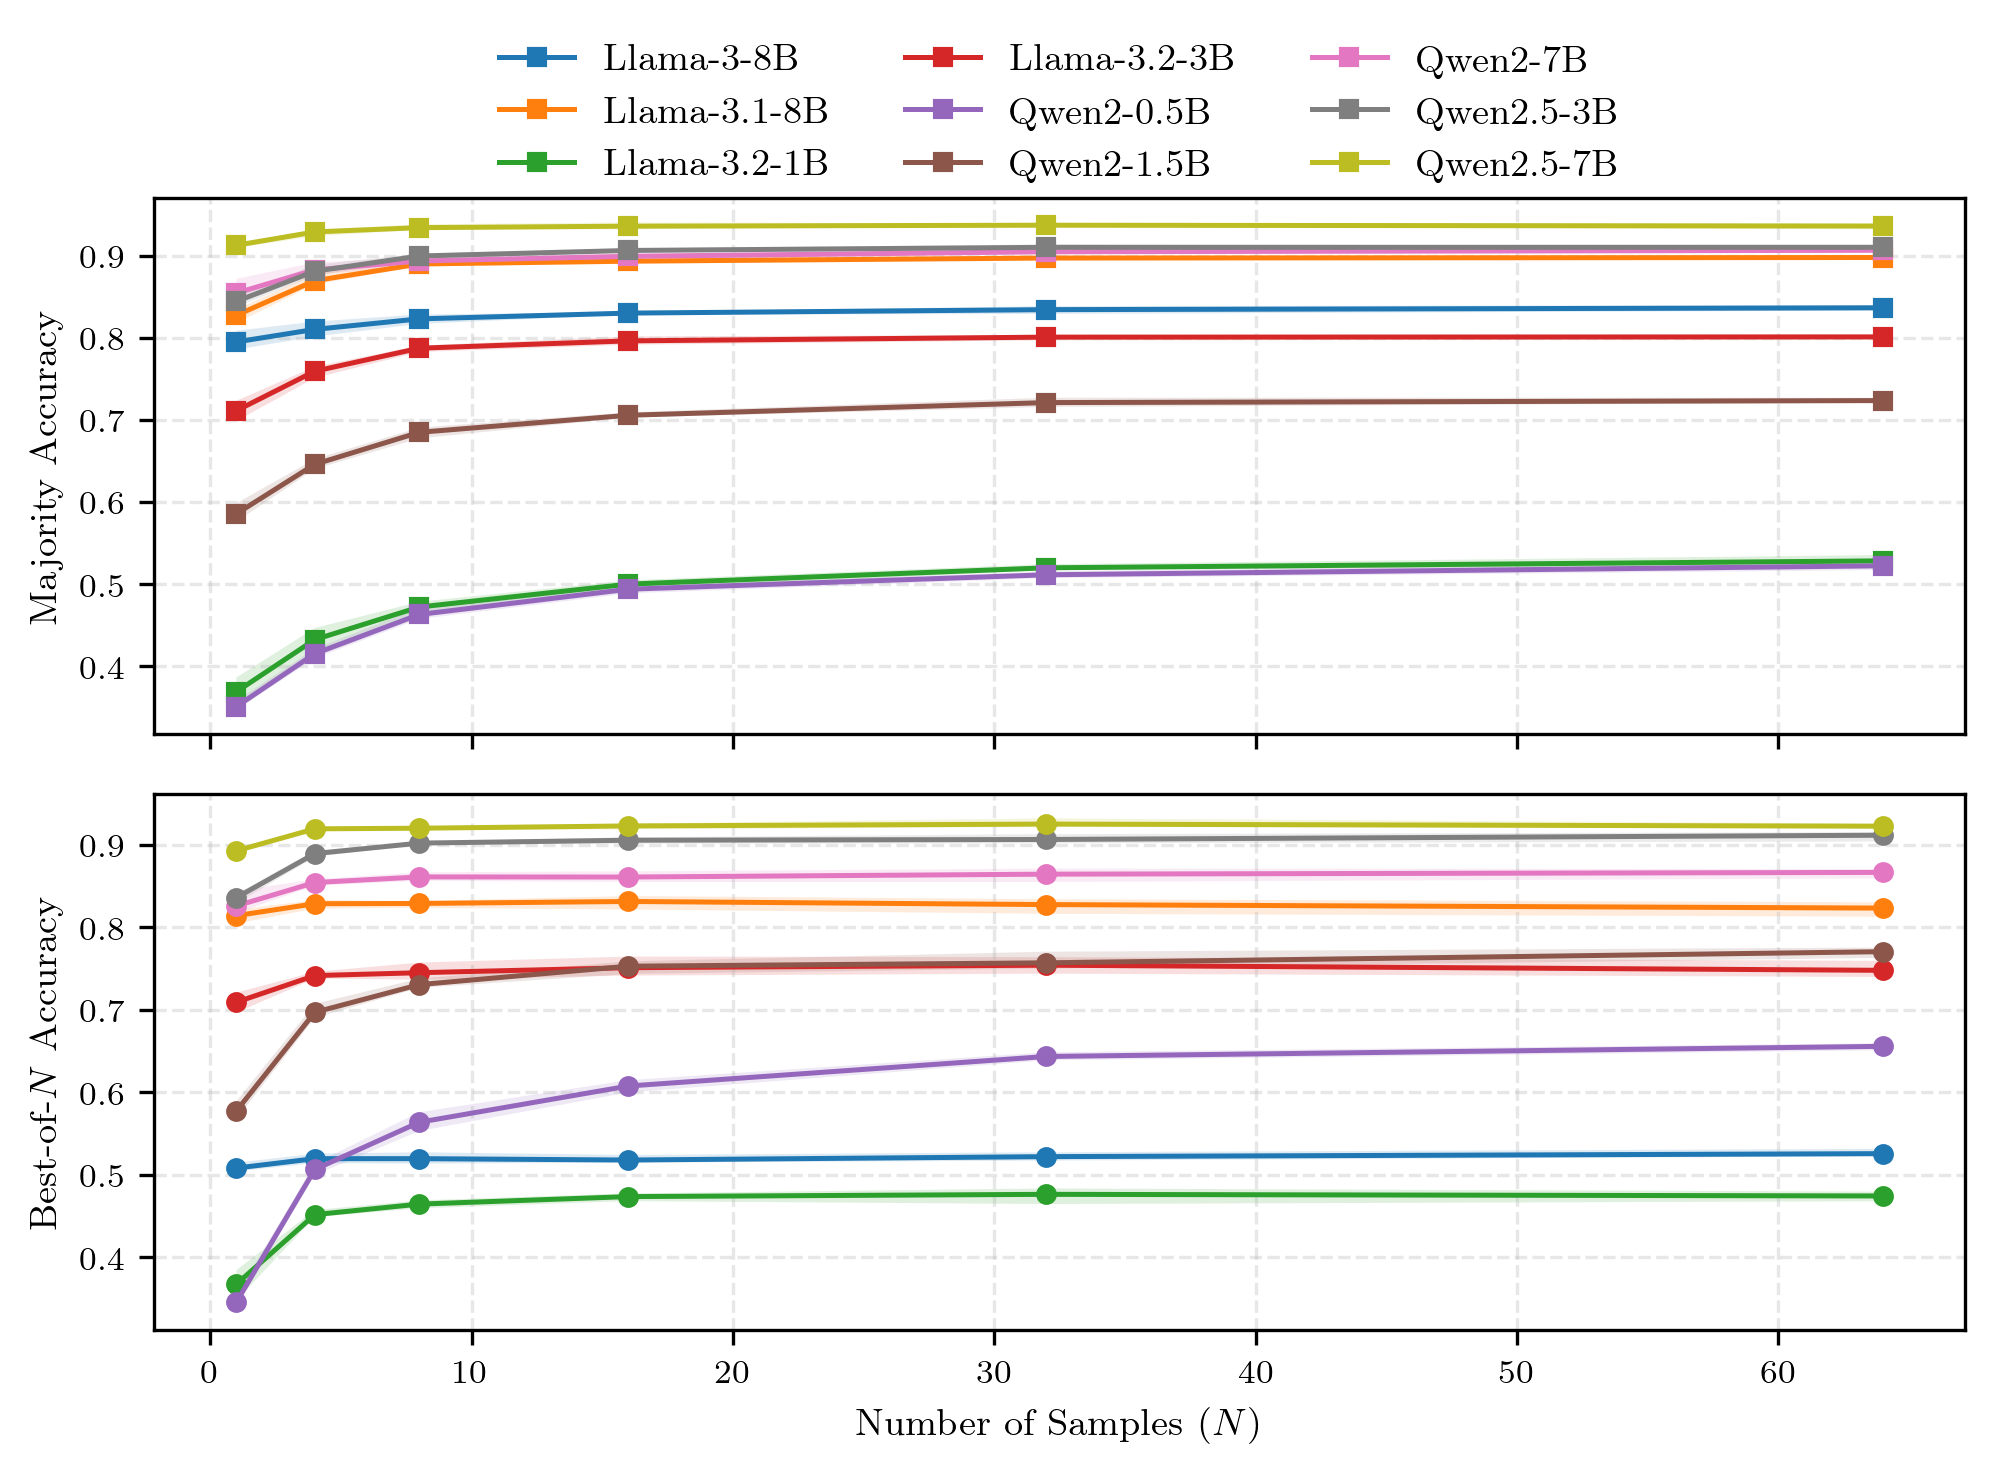

In [7]:
plot_all_curves(
    thetas,
    maj_mean,
    maj_std,
    rew_mean,
    rew_std,
    filename="../figures/GSM8K/curves_absolute.pdf",
)

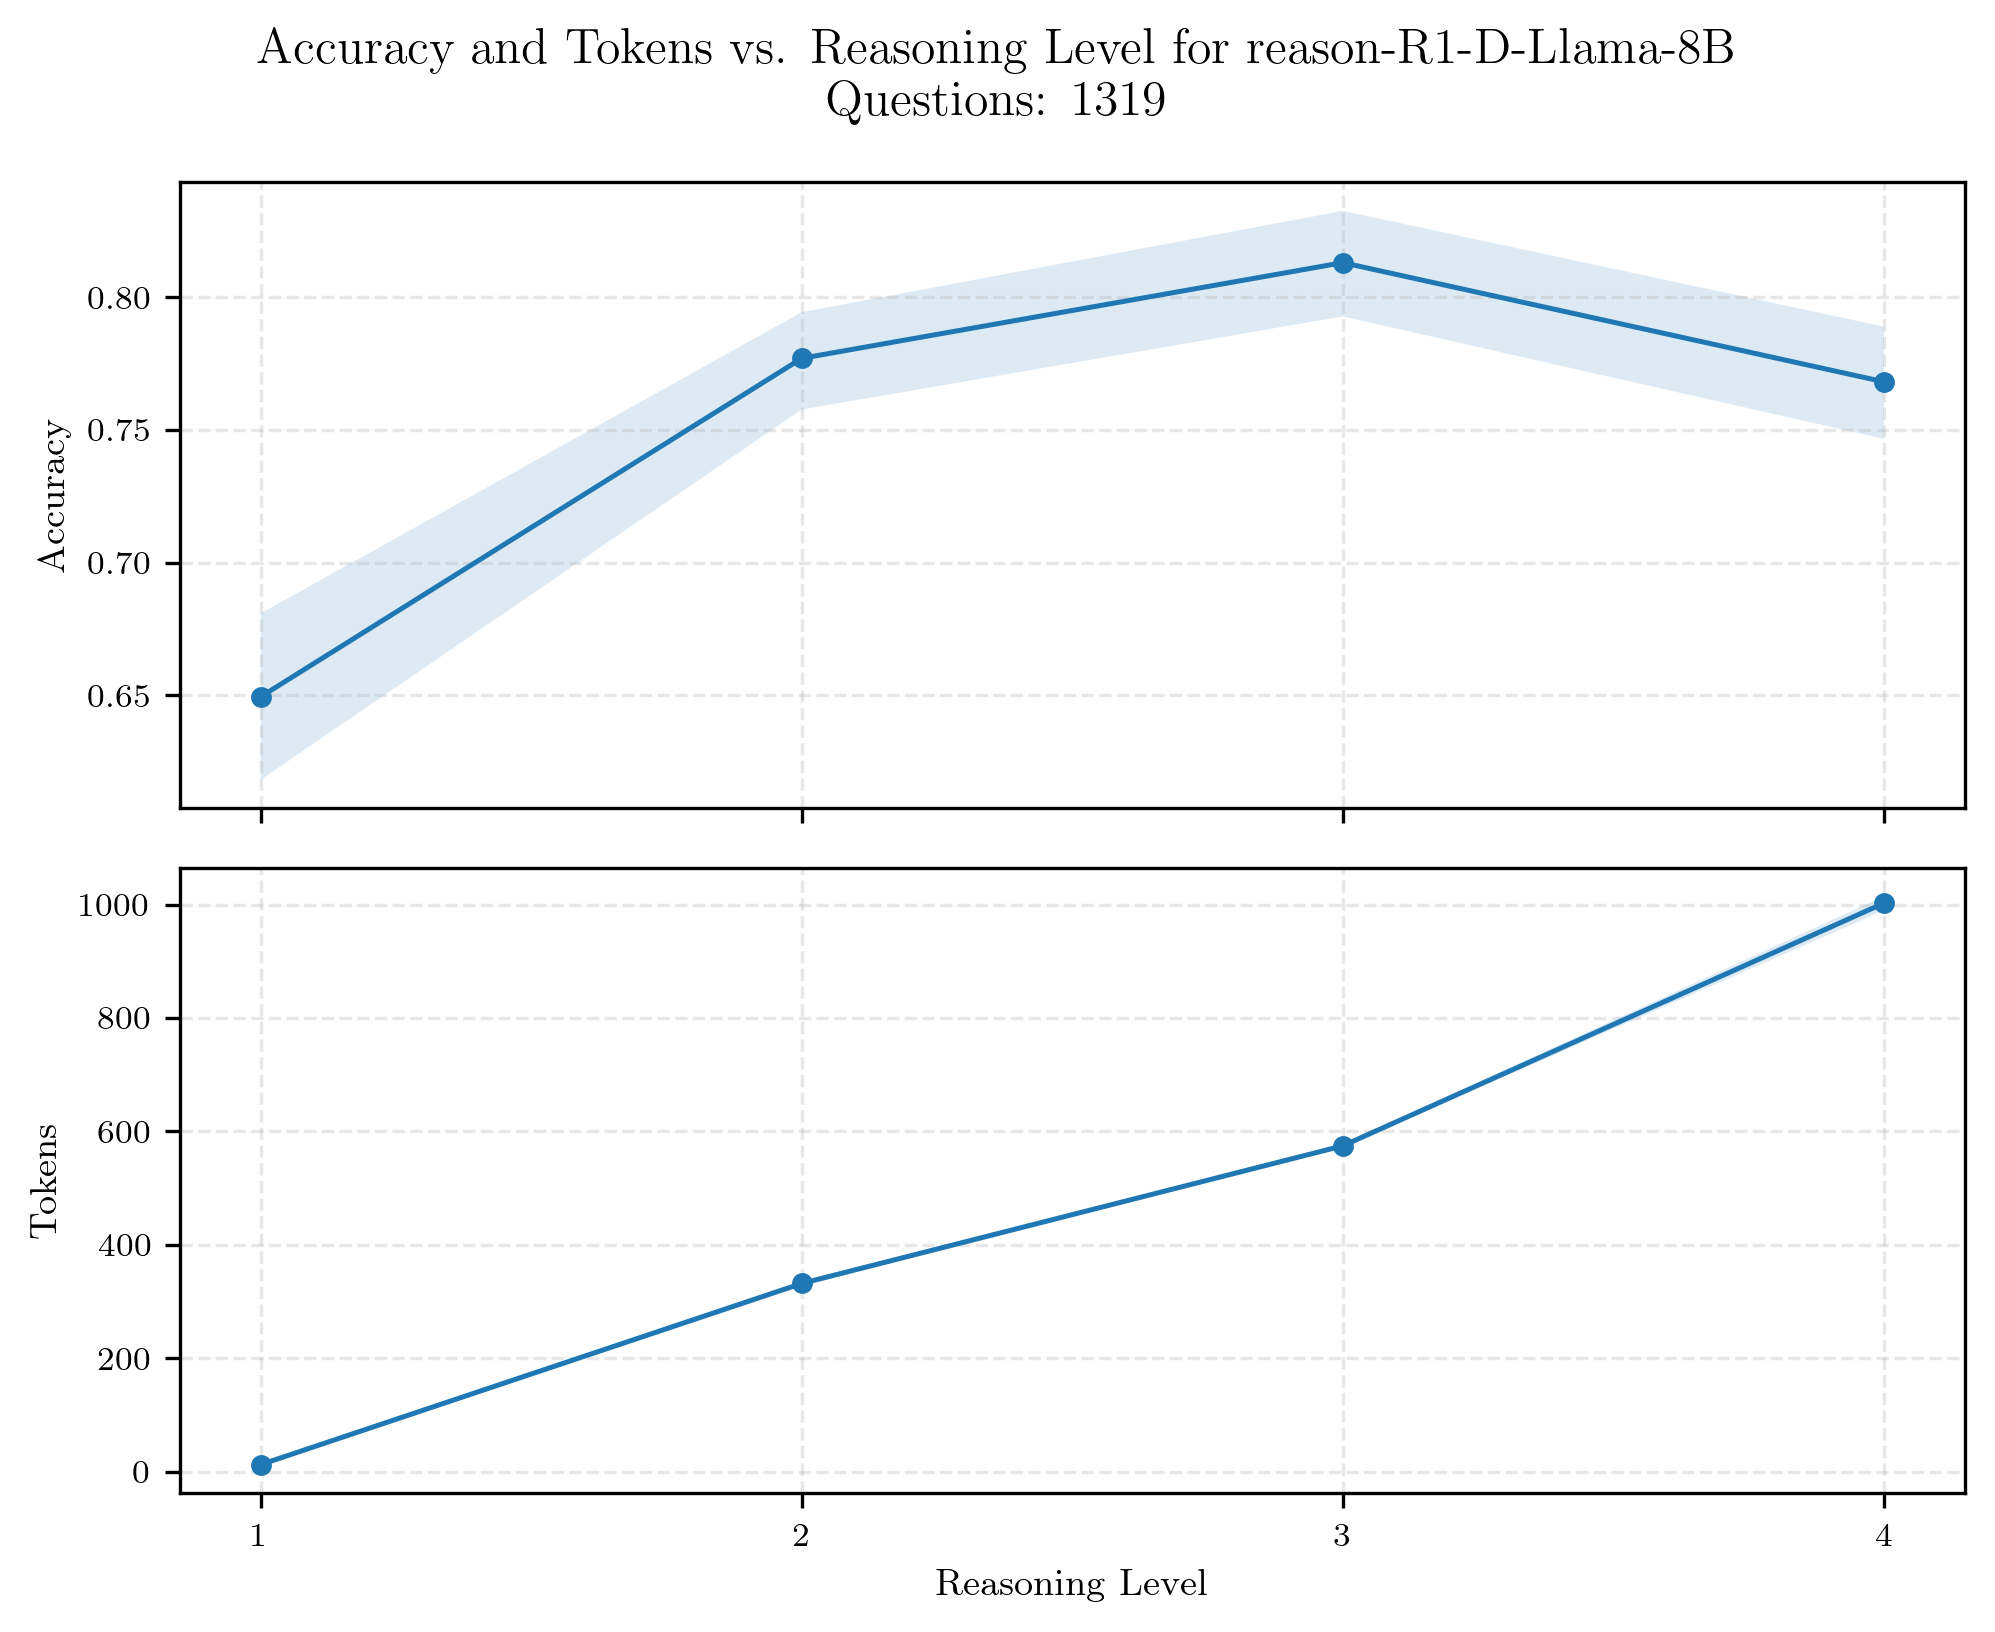

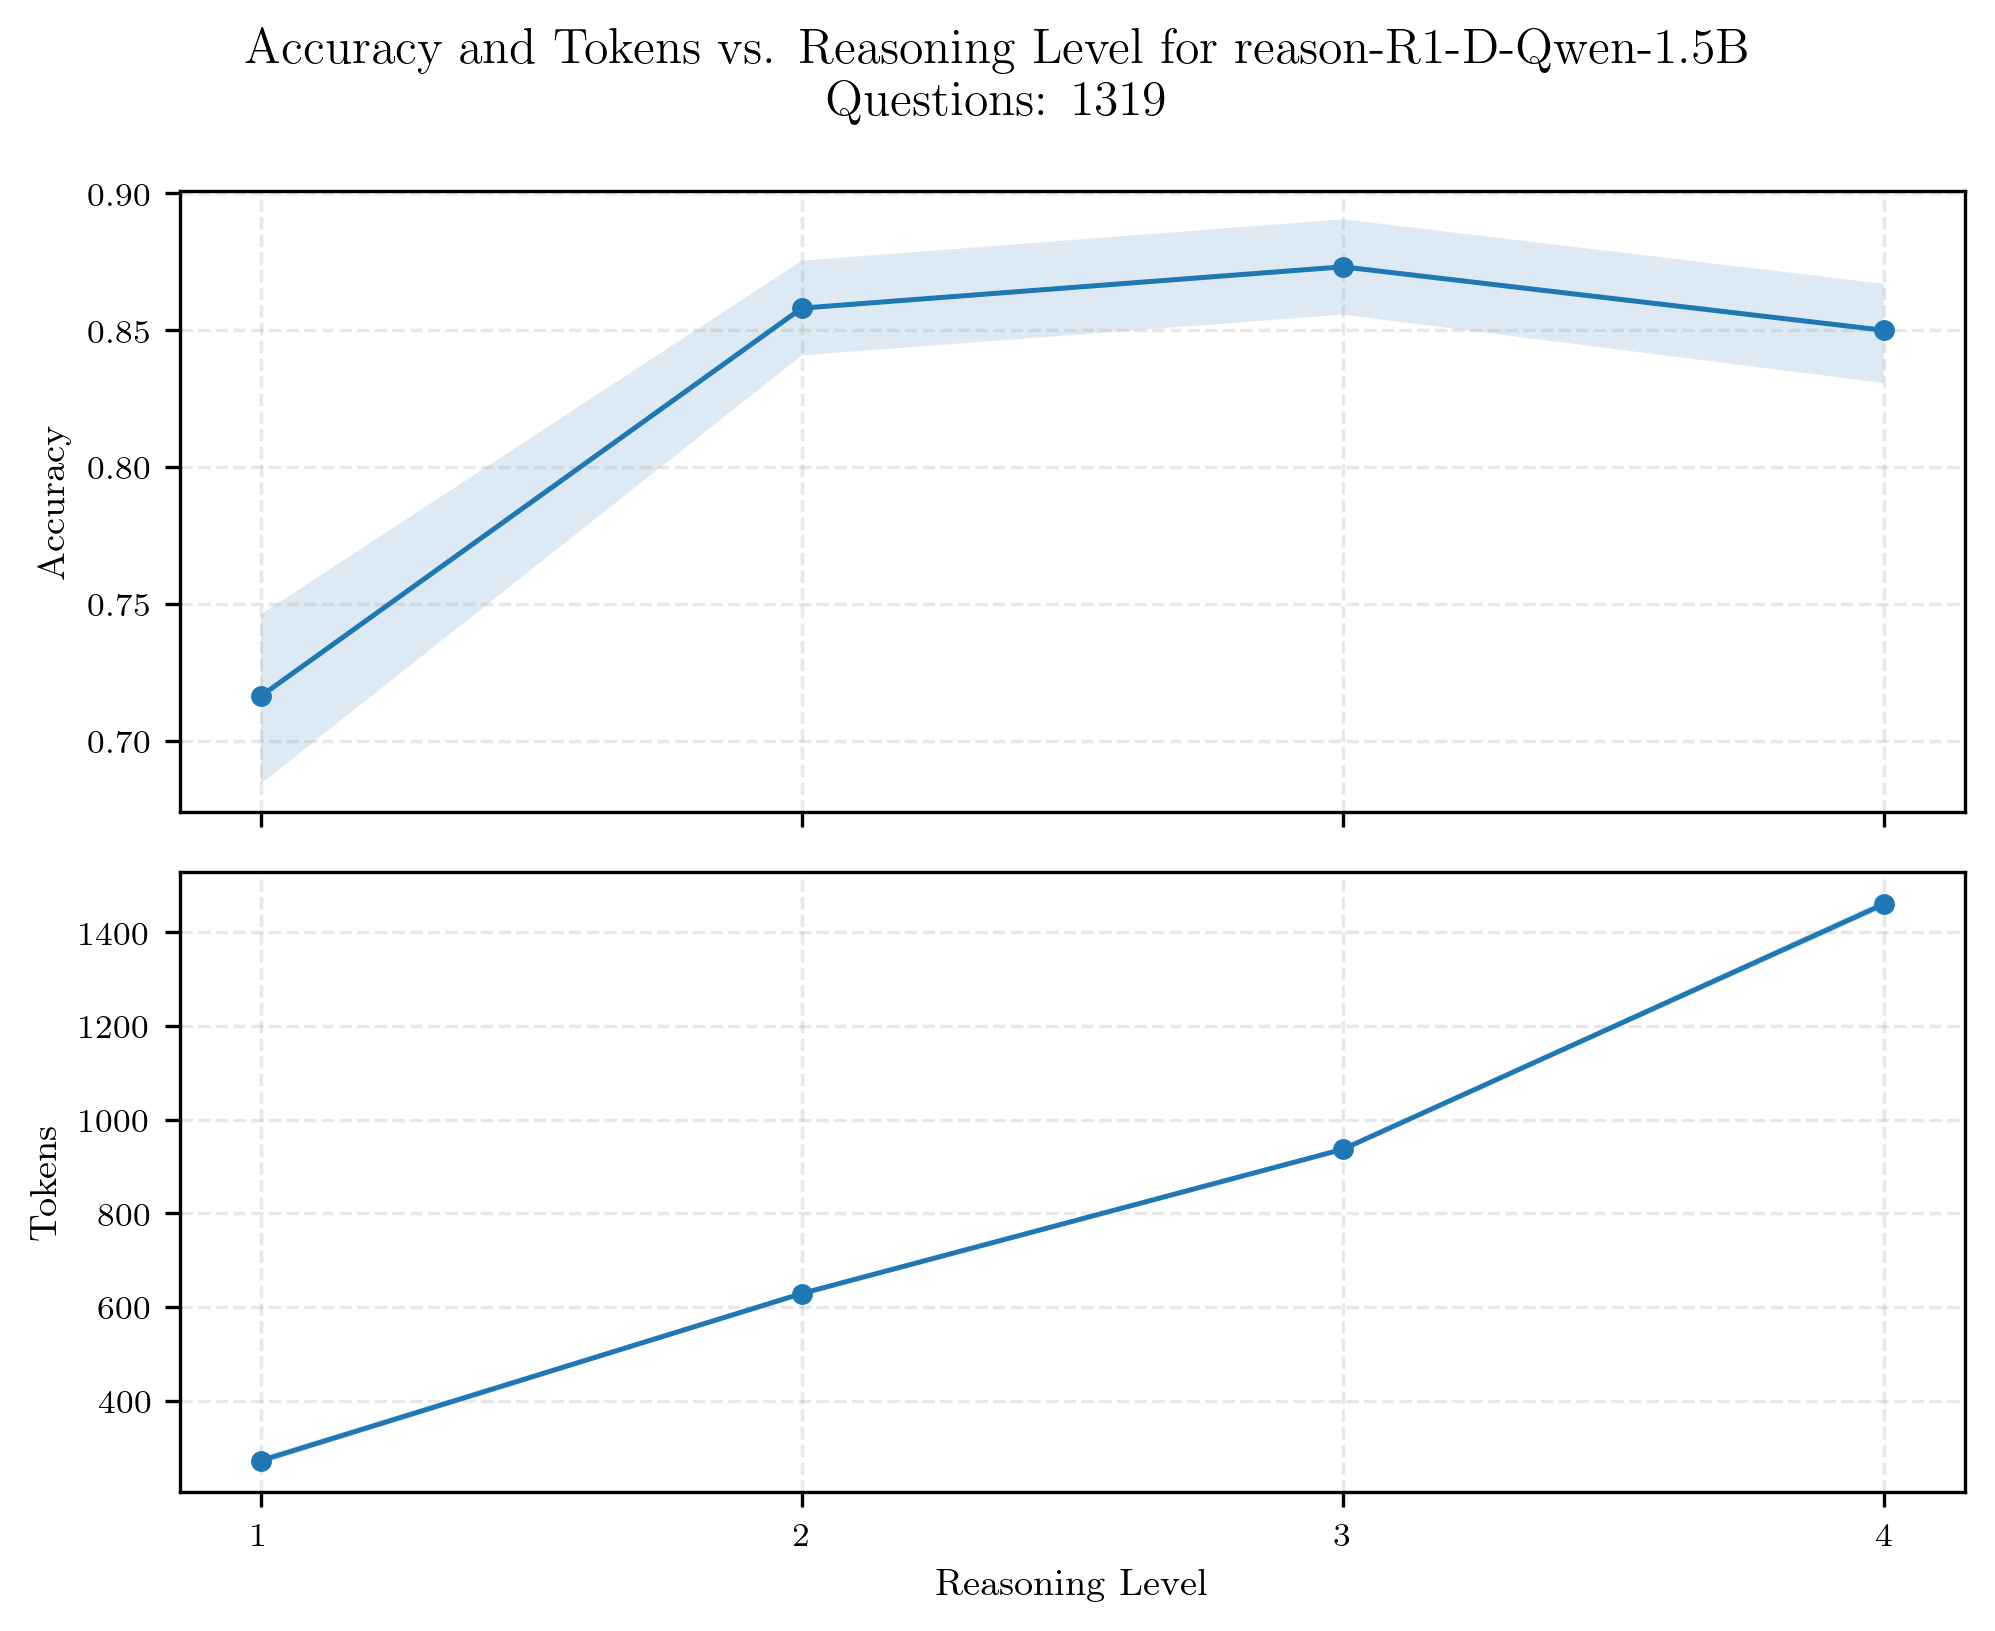

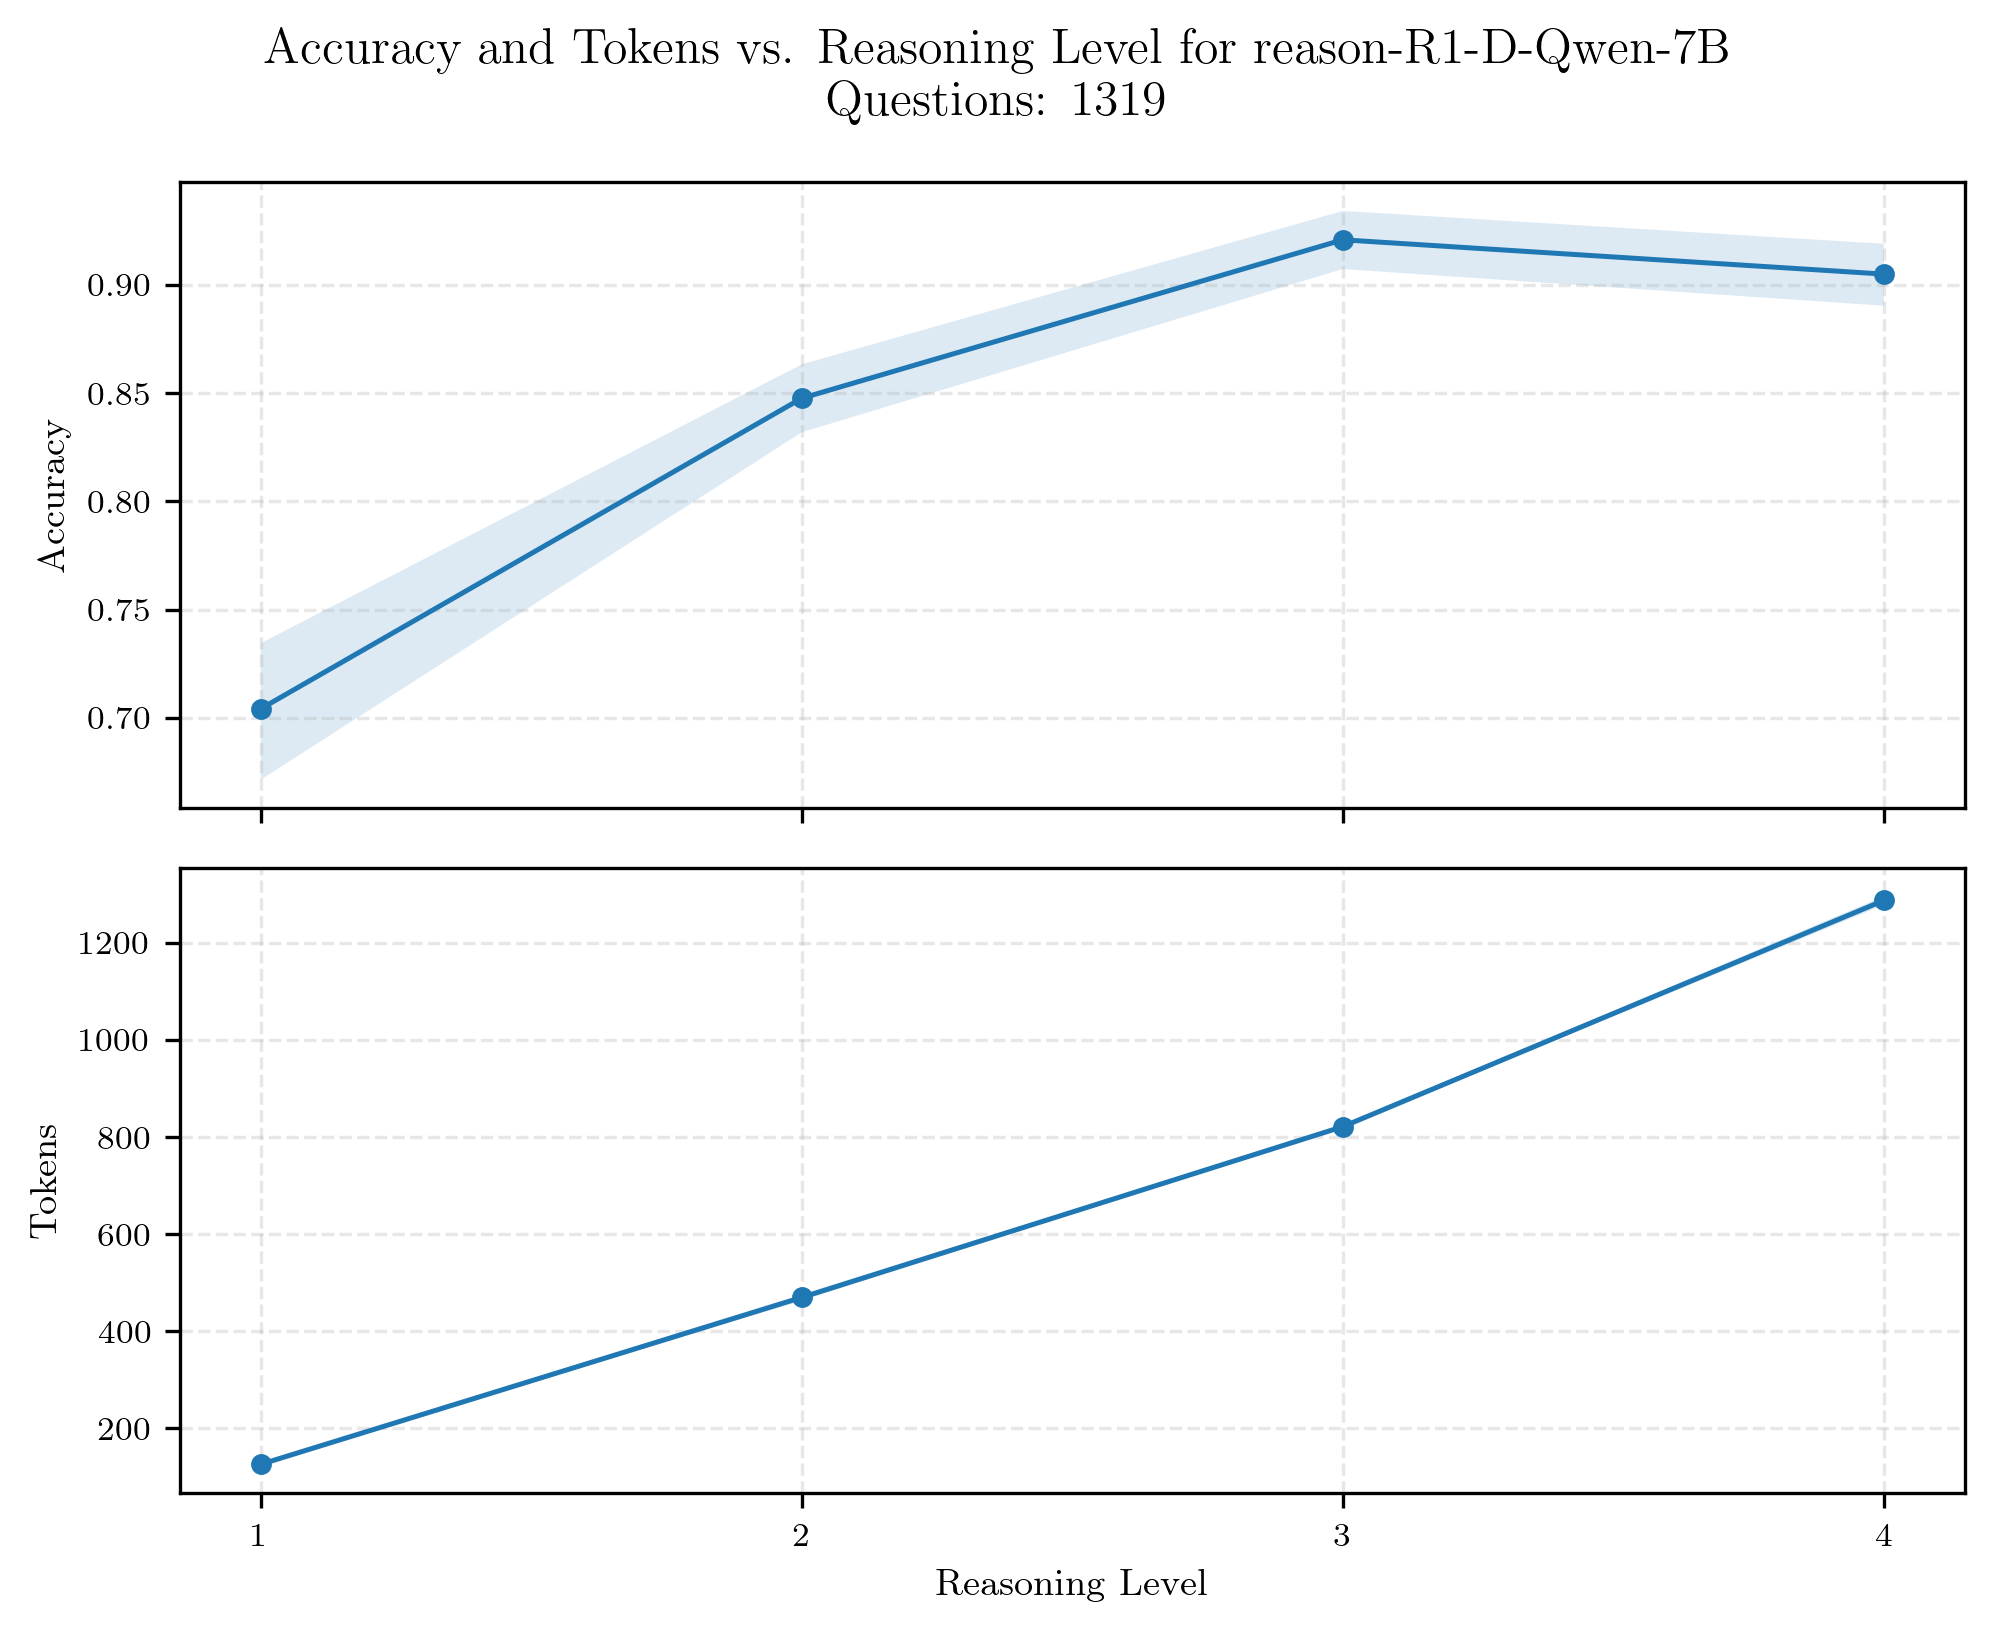

In [8]:
reasoning_accuracy = {}
reasoning_tokens = {}

for model_name in reasoning_models:
    means, stds, tokens, token_stds = reasoning_accuracy_curve_second_custom(
        results[model_name], qs=(0.0, 0.10, 0.50, 0.75, 1.0)
    )

    plot_reasoning_curves_accuracy_and_tokens(
        means, stds,
        tokens, token_stds,
        title="Accuracy and Tokens vs. Reasoning Level for " + model_name.split("--")[0],
        num_questions=len(results[model_name]["correct"]),
    )

    reasoning_accuracy[model_name] = means
    reasoning_tokens[model_name] = tokens


# Analysis

In [9]:
unreasoning_accuracy_majority = {}
unreasoning_tokens_majority = {}
unreasoning_accuracy_reward = {}
unreasoning_tokens_reward = {}

for model_name, data in results.items():
    if model_name in reasoning_models:
        continue
    unreasoning_accuracy_majority[model_name] = maj_mean[model_name]
    unreasoning_tokens_majority[model_name] = token_mean[model_name]
    unreasoning_accuracy_reward[model_name] = rew_mean[model_name]
    unreasoning_tokens_reward[model_name] = token_mean[model_name]

for model_name in reasoning_models:
    reasoning_accuracy[model_name] = np.asarray(reasoning_accuracy[model_name], dtype=np.float32)
    reasoning_tokens[model_name] = np.asarray(reasoning_tokens[model_name], dtype=np.float32)

In [10]:
for model_name in list(unreasoning_accuracy_majority.keys()):
    new_name = model_name.split("--")[0]
    unreasoning_accuracy_majority[new_name] = unreasoning_accuracy_majority.pop(model_name)
    unreasoning_tokens_majority[new_name] = unreasoning_tokens_majority.pop(model_name)
    unreasoning_accuracy_reward[new_name] = unreasoning_accuracy_reward.pop(model_name)
    unreasoning_tokens_reward[new_name] = unreasoning_tokens_reward.pop(model_name)

In [11]:
thetas = np.array([1, 4, 8, 16, 32, 64])

@dataclass
class MarketConfig:
    alpha: float = 10.0
    beta: float = 1.0
    default_margin: float = 0.25

    value_curve: str = "exp" # "linear", "power", "exp"
    baseline_frac: float = 0.1 

    kappa: float = 6.0 # for "exp"
    gamma: float = 3.5 # for "power"


MODEL_PRICES_PER_1M = {
    "Llama-3-8B": 0.1455,
    "Llama-3.1-8B": 0.1245,
    "Llama-3.2-1B": 0.10,
    "Llama-3.2-3B": 0.08,
    "Qwen2-0.5B": 0.10,
    "Qwen2-1.5B": 0.10,
    "Qwen2-7B": 0.20,
    "Qwen2.5-3B": 0.065,
    "Qwen2.5-7B": 0.1465,
}

class Provider:
    def __init__(
        self, 
        name: str, 
        base_model_key: str, 
        accuracy_curve: np.ndarray, 
        token_curve: np.ndarray, 
        margin: Optional[float] = None
    ):
        self.name = name
        self.accuracy_curve = accuracy_curve
        self.token_curve = token_curve
        

        price_per_1m = 0.0
        for key, price in MODEL_PRICES_PER_1M.items():
            if key in base_model_key:
                price_per_1m = price
                break
        
        if price_per_1m == 0.0:
            print(f"Warning: No price found for {base_model_key}, defaulting to $0.10")
            price_per_1m = 0.10
            
        self.price_per_token = price_per_1m # / 1_000_000
        self.margin = margin  

    def get_economics(self, theta_idx: int, config: MarketConfig):
        raw_accuracy = float(self.accuracy_curve[theta_idx])
        raw_tokens = float(self.token_curve[theta_idx])

        p_theta = raw_tokens * self.price_per_token
        c_theta = p_theta / (1 + self.margin)

        a = float(raw_accuracy)
        b = float(config.baseline_frac)

        if config.value_curve == "linear":
            f = a
        elif config.value_curve == "power":
            f = a ** config.gamma
        elif config.value_curve == "exp":
            denom = np.expm1(config.kappa)
            f = (np.expm1(config.kappa * a) / denom) if denom != 0 else a
        else:
            raise ValueError(f"Unknown value_curve: {config.value_curve}")

        q_theta = config.alpha * (b + (1 - b) * f)

        v_theta = q_theta - p_theta

        return {
            "q": q_theta,
            "p": p_theta,
            "c": c_theta,
            "V": v_theta,
            "raw_acc": raw_accuracy,
            "profit_margin": p_theta - c_theta
        }

In [12]:
providers = []

for model_name in unreasoning_accuracy_majority.keys():
    key = model_name
    provider = Provider(
        name=model_name,
        base_model_key=key,
        accuracy_curve=unreasoning_accuracy_majority[key],
        token_curve=unreasoning_tokens_majority[key],
        margin=0.25
    )
    providers.append(provider)

In [13]:
def compute_V_curves(providers, config):
    V = {}
    for pr in providers:
        V[pr.name] = np.array([pr.get_economics(i, config)["V"] for i in range(len(thetas))], dtype=float)
    return V

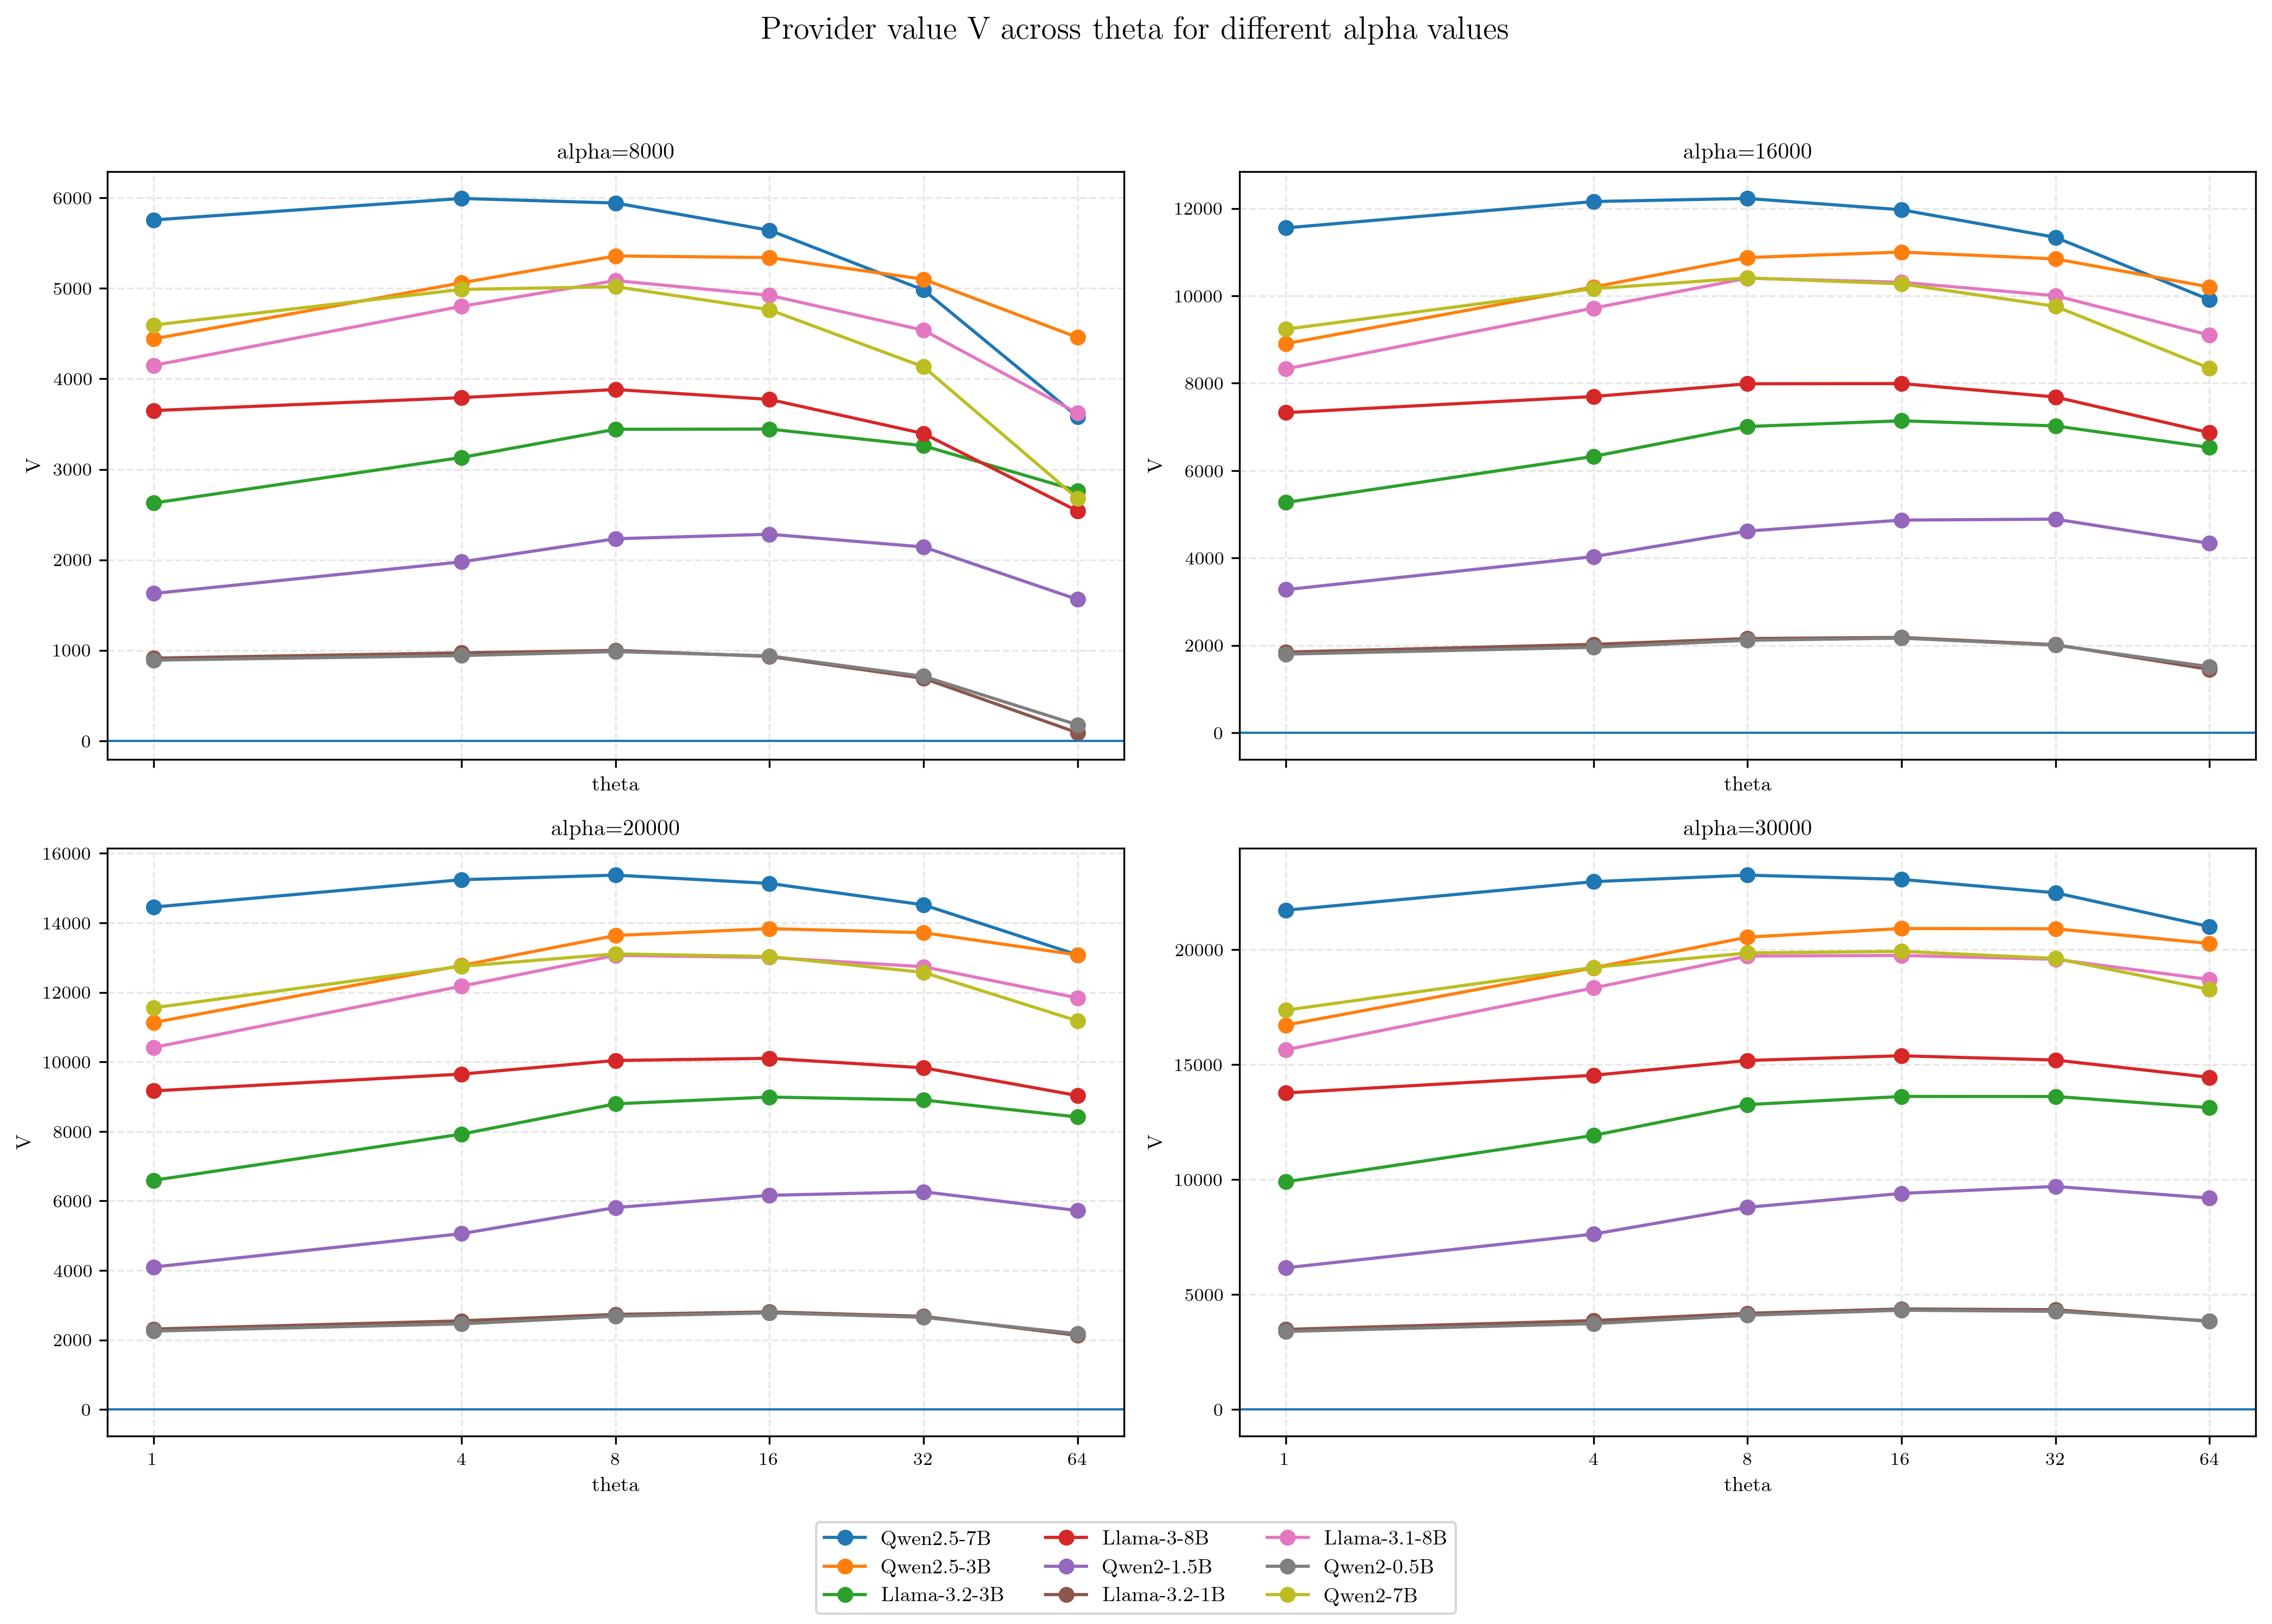

In [14]:
alpha_grid = [8000, 16000, 20000, 30000]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.ravel()

for ax, a in zip(axes, alpha_grid):
    cfg = MarketConfig(alpha=a, beta=5, default_margin=0.25, value_curve="power", gamma=4)
    Vc = compute_V_curves(providers, cfg)
    for name, v in Vc.items():
        ax.plot(thetas, v, marker="o", linewidth=1.4, label=name)
    ax.axhline(0, linewidth=1)
    ax.set_xscale("log", base=2)
    ax.set_xticks(thetas)
    ax.set_xticklabels([str(t) for t in thetas])
    ax.set_title(f"alpha={a}")
    ax.set_xlabel("theta")
    ax.set_ylabel("V")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=9, frameon=True)

fig.suptitle("Provider value V across theta for different alpha values", y=0.98, fontsize=14)
fig.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.show()

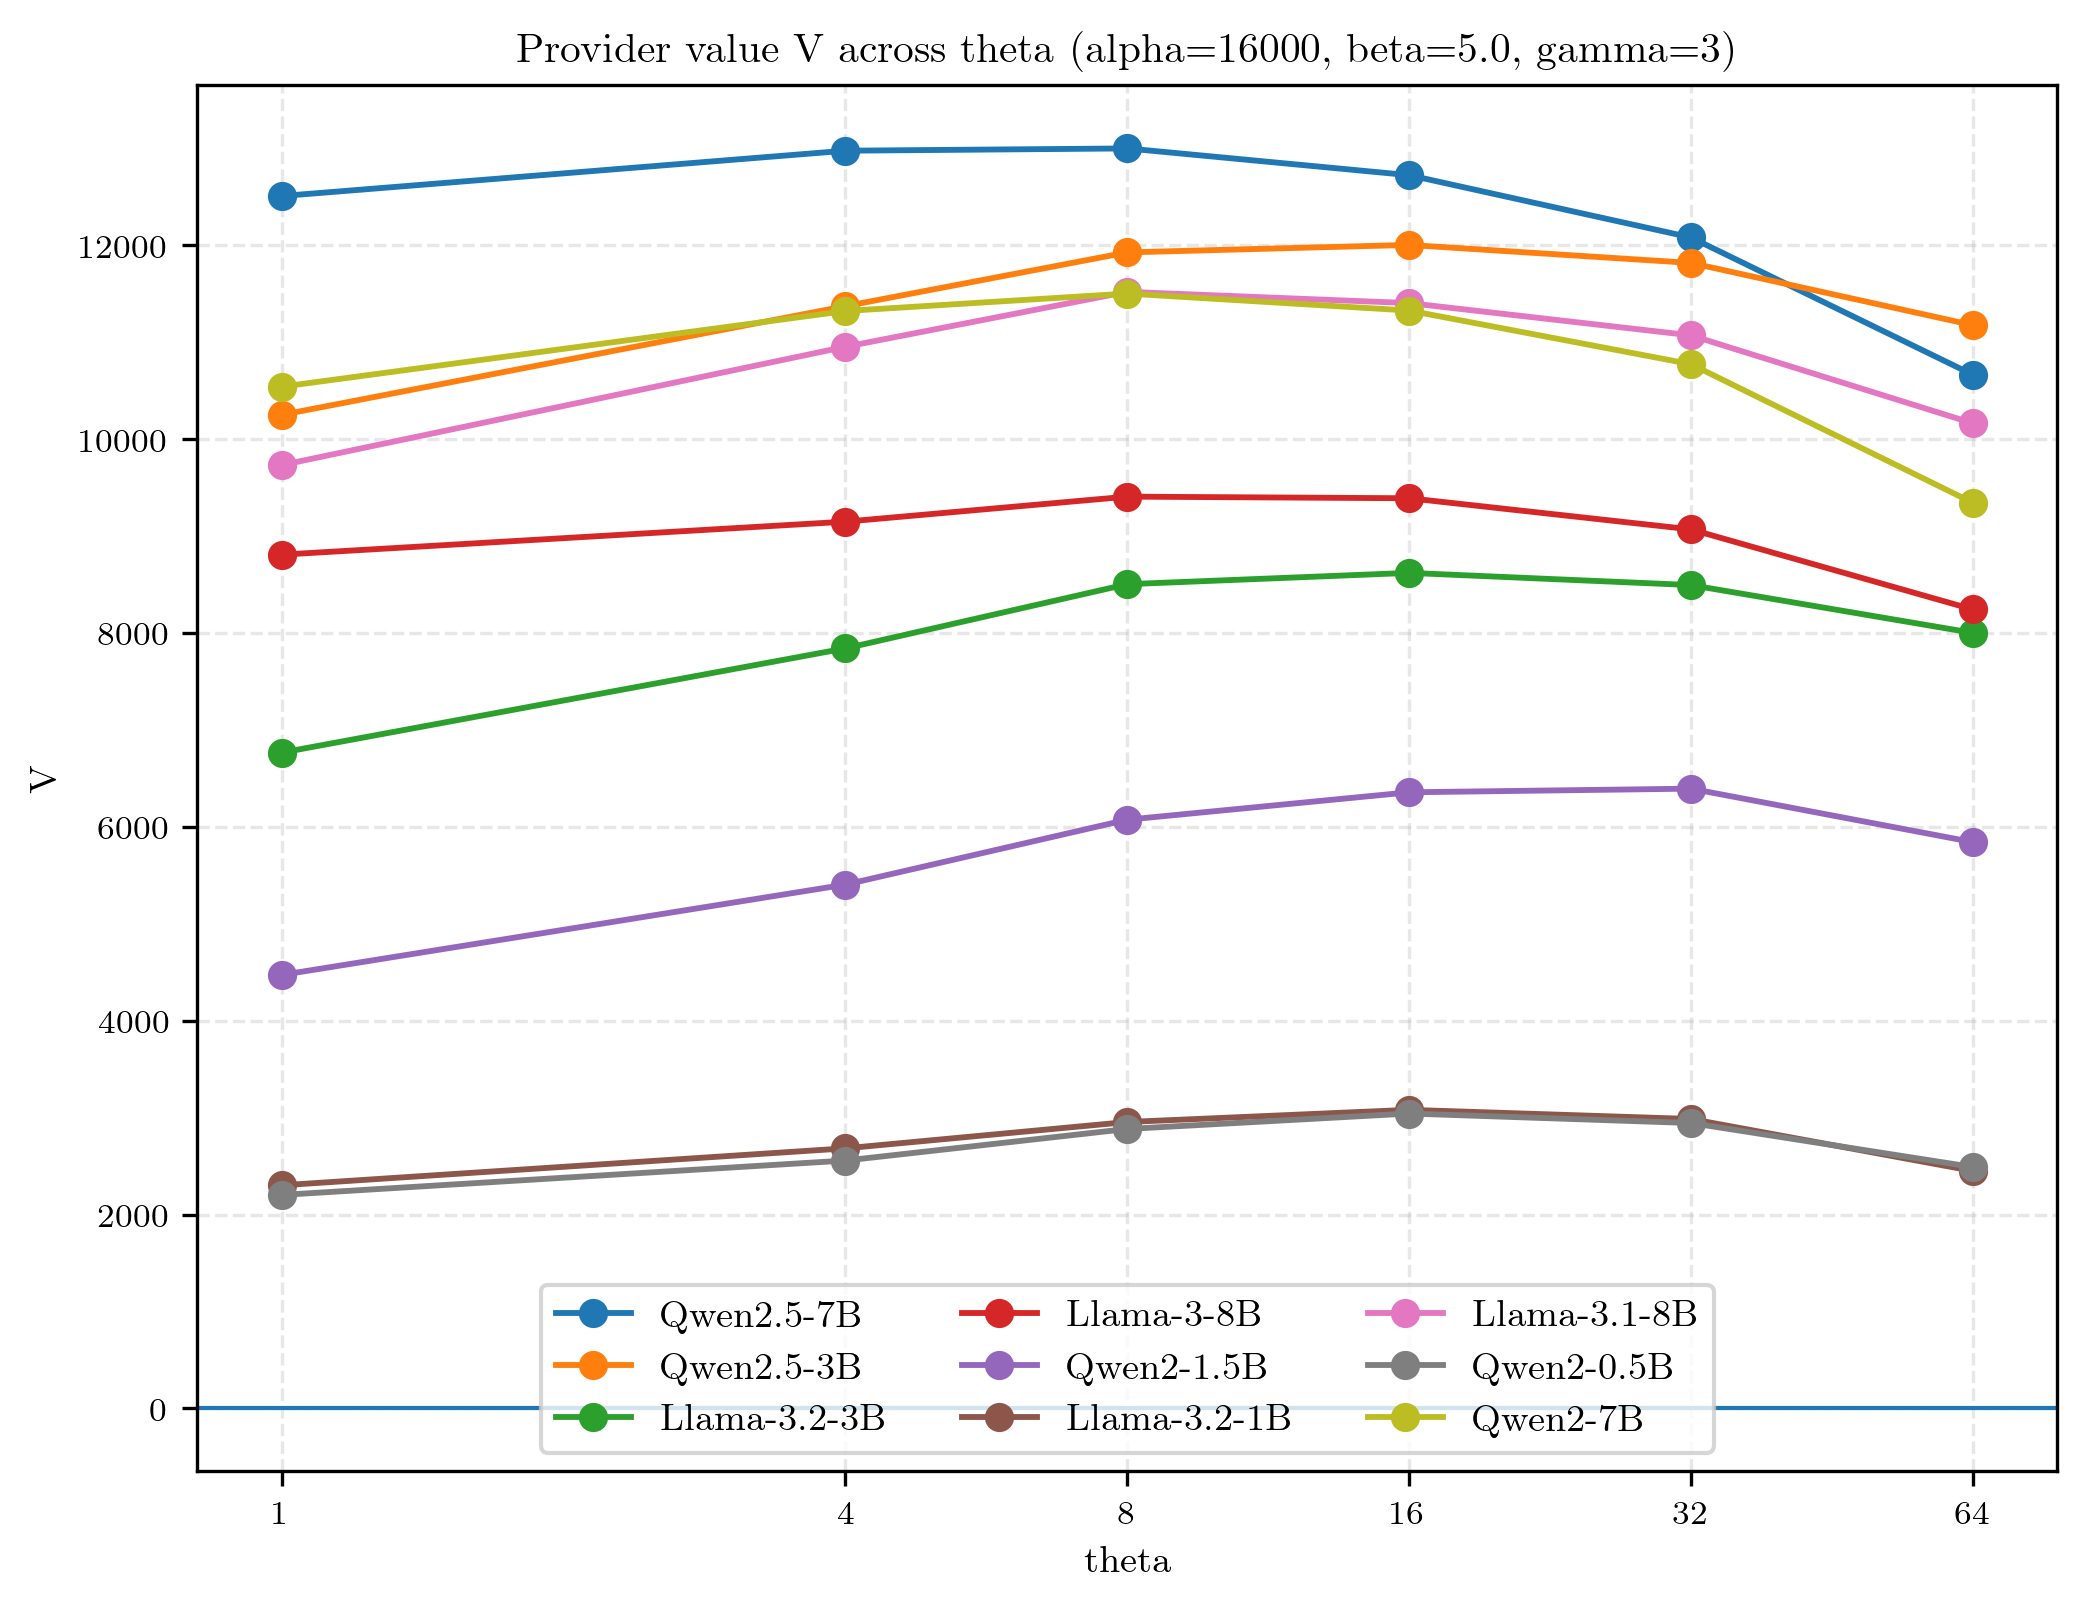

In [15]:
config = MarketConfig(
    alpha=16000,       
    beta=5.0,
    gamma=3,
    default_margin=0.25,
    value_curve="power",
)

V_curves = compute_V_curves(providers, config)

fig, ax = plt.subplots(figsize=(8, 6))

for name, v in V_curves.items():
    ax.plot(thetas, v, marker="o", linewidth=1.4, label=name)
ax.axhline(0, linewidth=1)
ax.set_xscale("log", base=2)
ax.set_xticks(thetas)
ax.set_xticklabels([str(t) for t in thetas])
ax.set_title(f"Provider value V across theta (alpha={config.alpha}, beta={config.beta}, gamma={config.gamma})")
ax.set_xlabel("theta")
ax.set_ylabel("V")
ax.legend(loc="lower center", ncol=3, fontsize=9, frameon=True)
plt.show()

In [16]:
def get_market_shares(values: np.ndarray, beta: float, v0: float = 0.0) -> np.ndarray:
    max_val = np.max(np.append(values, v0))
    
    exp_values = np.exp(beta * (values - max_val))
    exp_v0 = np.exp(beta * (v0 - max_val))
    
    denominator = exp_v0 + np.sum(exp_values)
    return exp_values / denominator

def get_utility(share: float, p: float, c: float) -> float:
    return share * (p - c)

In [17]:
def get_global_max_welfare(providers: List[Provider], config: MarketConfig) -> float:
    max_welfare = -np.inf
    
    for p in providers:
        for theta_idx in range(len(p.accuracy_curve)):
            econ = p.get_economics(theta_idx, config)
            welfare = econ['q'] - econ['c']
            if welfare > max_welfare:
                max_welfare = welfare
                
    return max_welfare

def calculate_current_welfare(
    providers: List[Provider], 
    strategies: np.ndarray, 
    shares: np.ndarray, 
    config: MarketConfig
) -> float:
    total_welfare = 0.0
    for i, p in enumerate(providers):
        theta_idx = strategies[i]
        econ = p.get_economics(theta_idx, config)
        sw_i = econ['q'] - econ['c']
        total_welfare += shares[i] * sw_i
        
    return total_welfare

In [ ]:
def run_simulation_sequential_robust(
    providers: List[Provider], 
    config: MarketConfig, 
    max_iter: int = 50,
    v0: float = 0.0,
    tolerance: float = 0.01
):
    num_providers = len(providers)
    num_strategies = len(providers[0].accuracy_curve)
    
    max_possible_sw = get_global_max_welfare(providers, config)
    
    current_strategies = np.zeros(num_providers, dtype=int)
    
    history = {p.name: [0] for p in providers} 
    poa_history = []
    
    init_economics = [prov.get_economics(0, config) for prov in providers]
    init_Vs = np.array([e['V'] for e in init_economics])
    init_shares = get_market_shares(init_Vs, config.beta, v0)
    init_sw = calculate_current_welfare(providers, current_strategies, init_shares, config)
    poa_history.append(1.0 if init_sw <= 1e-9 else max_possible_sw / init_sw)

    provider_indices = list(range(num_providers))

    for t in range(max_iter):
        strategies_changed_this_round = False
        
        random.shuffle(provider_indices)
        
        for i in provider_indices:
            p = providers[i]
            
            current_economics = [prov.get_economics(current_strategies[k], config) 
                                 for k, prov in enumerate(providers)]
            current_Vs = np.array([e['V'] for e in current_economics])
            
            current_shares = get_market_shares(current_Vs, config.beta, v0)
            current_econ = current_economics[i]
            current_util = get_utility(current_shares[i], current_econ['p'], current_econ['c'])
            
            best_util = current_util
            target_strat_idx = current_strategies[i] 
            
            other_Vs = current_Vs.copy()

            for theta_candidate in range(num_strategies):
                if theta_candidate == current_strategies[i]:
                    continue 
                    
                cand_econ = p.get_economics(theta_candidate, config)
                cand_V = cand_econ['V']
                
                hypothetical_Vs = other_Vs.copy()
                hypothetical_Vs[i] = cand_V
                
                shares = get_market_shares(hypothetical_Vs, config.beta, v0)
                util = get_utility(shares[i], cand_econ['p'], cand_econ['c'])
                
                if best_util > 0:
                    improvement_threshold = best_util * (1 + tolerance)
                else:
                    improvement_threshold = best_util + 1e-5
                
                if util > improvement_threshold:
                    best_util = util
                    target_strat_idx = theta_candidate
            
            current_idx = current_strategies[i]
            new_idx = current_idx

            if target_strat_idx > current_idx:
                new_idx = current_idx + 1
            elif target_strat_idx < current_idx:
                new_idx = current_idx - 1
            
            if new_idx != current_idx:
                current_strategies[i] = new_idx
                strategies_changed_this_round = True
            
            for k, prov in enumerate(providers):
                history[prov.name].append(int(current_strategies[k]))
                
            micro_economics = [prov.get_economics(current_strategies[k], config) for k, prov in enumerate(providers)]
            micro_Vs = np.array([e['V'] for e in micro_economics])
            micro_shares = get_market_shares(micro_Vs, config.beta, v0)
            micro_sw = calculate_current_welfare(providers, current_strategies, micro_shares, config)
            
            poa = 1.0 if micro_sw <= 1e-9 else max_possible_sw / micro_sw
            poa_history.append(poa)

        if not strategies_changed_this_round:
            break

    return history, poa_history

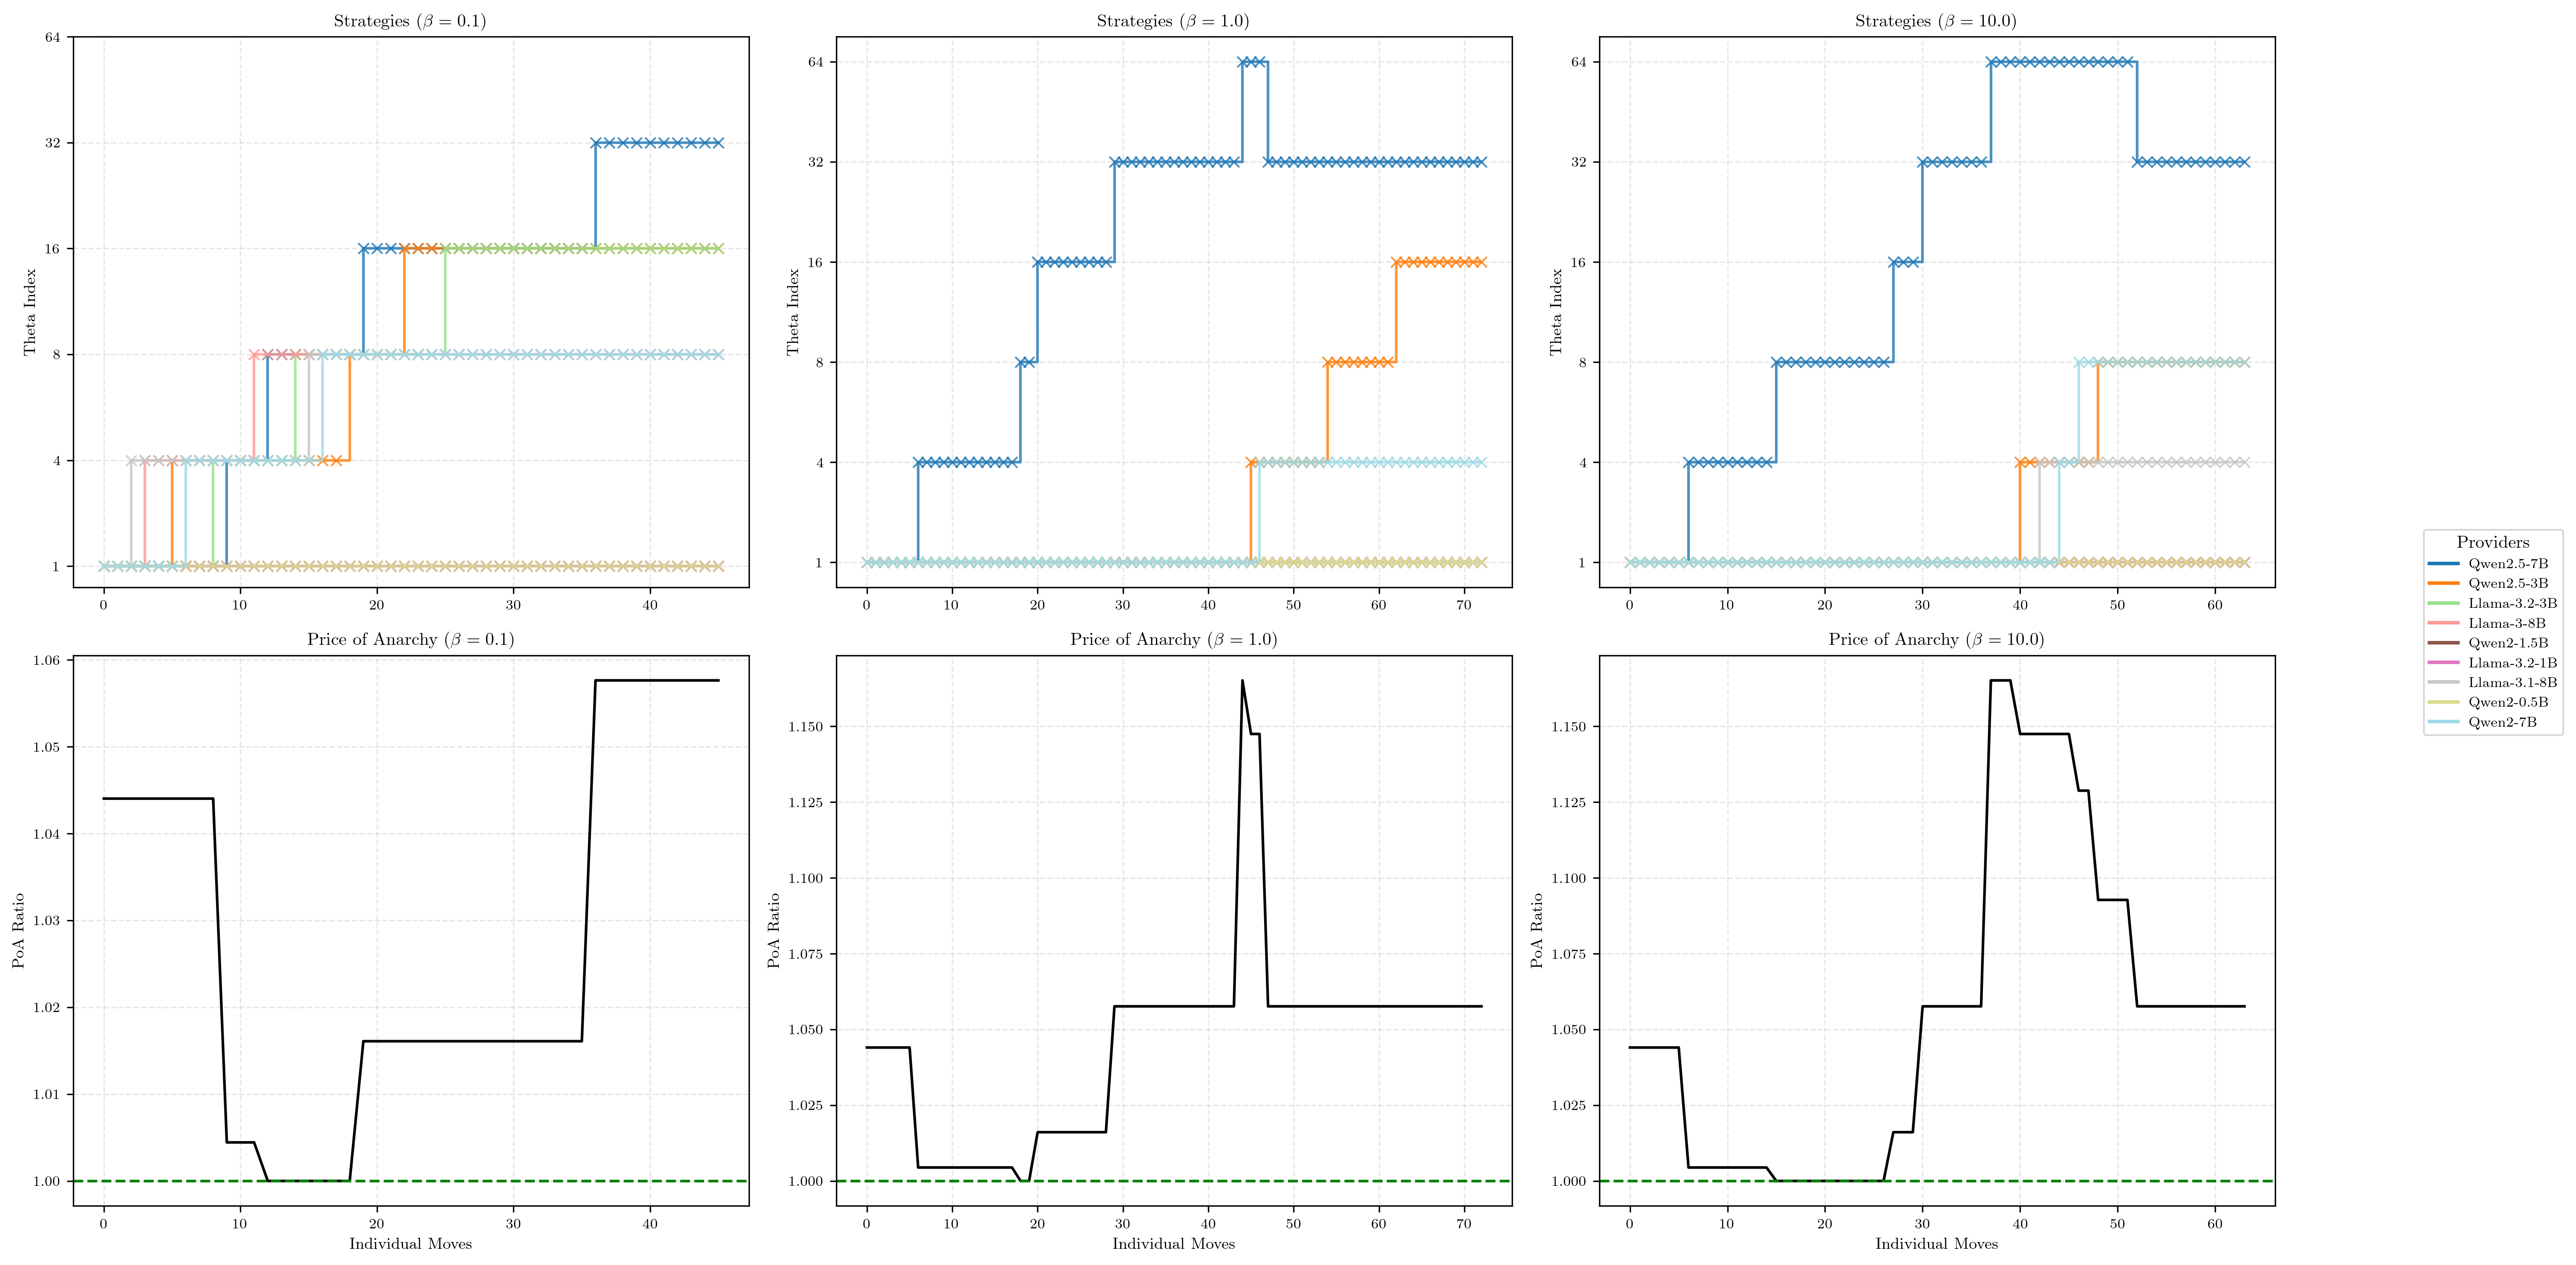

In [19]:
betas_to_test = [0.1, 1.0, 10.0]

results = {}

for b in betas_to_test:
    sim_config = copy.copy(config)
    sim_config.beta = b

    results[b] = run_simulation_sequential_robust(
        providers, 
        sim_config, 
        max_iter=1000, 
        v0=0.0, 
        tolerance=0.01
    )

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False)

colors = plt.cm.tab20(np.linspace(0, 1, len(providers)))
color_map = {p.name: colors[i] for i, p in enumerate(providers)}

for col_idx, beta in enumerate(betas_to_test):
    history, poa_hist = results[beta]
    total_steps = len(poa_hist)
    steps = range(total_steps)
    
    ax_strat = axes[0, col_idx]
    
    for provider_name, trajectory in history.items():
        traj_to_plot = trajectory[:total_steps]
        
        ax_strat.plot(
            steps, 
            traj_to_plot, 
            marker='x',     
            drawstyle='steps-post', 
            linewidth=1.5,
            color=color_map[provider_name],
            alpha=0.8
        )
    
    ax_strat.set_title(f"Strategies ($\\beta={beta}$)")
    ax_strat.set_ylabel("Theta Index")
    ax_strat.set_yticks(range(len(thetas)))
    ax_strat.set_yticklabels([str(t) for t in thetas])
    ax_strat.grid(True, linestyle='--', alpha=0.3)

    ax_poa = axes[1, col_idx]
    ax_poa.plot(steps, poa_hist, color='black', linewidth=1.5, label='PoA')
    ax_poa.axhline(1.0, color='green', linestyle='--', linewidth=1.5, label='Optimal (1.0)')
    
    ax_poa.set_title(f"Price of Anarchy ($\\beta={beta}$)")
    ax_poa.set_xlabel("Individual Moves")
    ax_poa.set_ylabel("PoA Ratio")
    ax_poa.grid(True, linestyle='--', alpha=0.3)
    
    if len(poa_hist) > 0:
        min_poa = min(poa_hist)
        max_poa = max(poa_hist)
        margin = (max_poa - min_poa) * 0.05
        if margin == 0: margin = 0.05
        ax_poa.set_ylim(bottom=max(0.9, min_poa - margin), top=max_poa + margin)


patches = [
    plt.Line2D([0], [0], color=color_map[p.name], lw=2, label=p.name) 
    for p in providers
]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.12, 0.5), title="Providers")

plt.tight_layout()
plt.show()

In [20]:
def sweep_beta_vs_poa(
    providers: List[Provider], 
    base_config: MarketConfig, 
    beta_values: np.ndarray
):
    final_poas = []
        
    for i, b in enumerate(beta_values):
        sim_config = copy.copy(base_config)
        sim_config.beta = b
        
        _, poa_hist = run_simulation_sequential_robust(
            providers, 
            sim_config, 
            max_iter=1000,      
            v0=0.0, 
            tolerance=0.01  
        )
        
        final_poa = poa_hist[-1]
        final_poas.append(final_poa)
            
    return final_poas

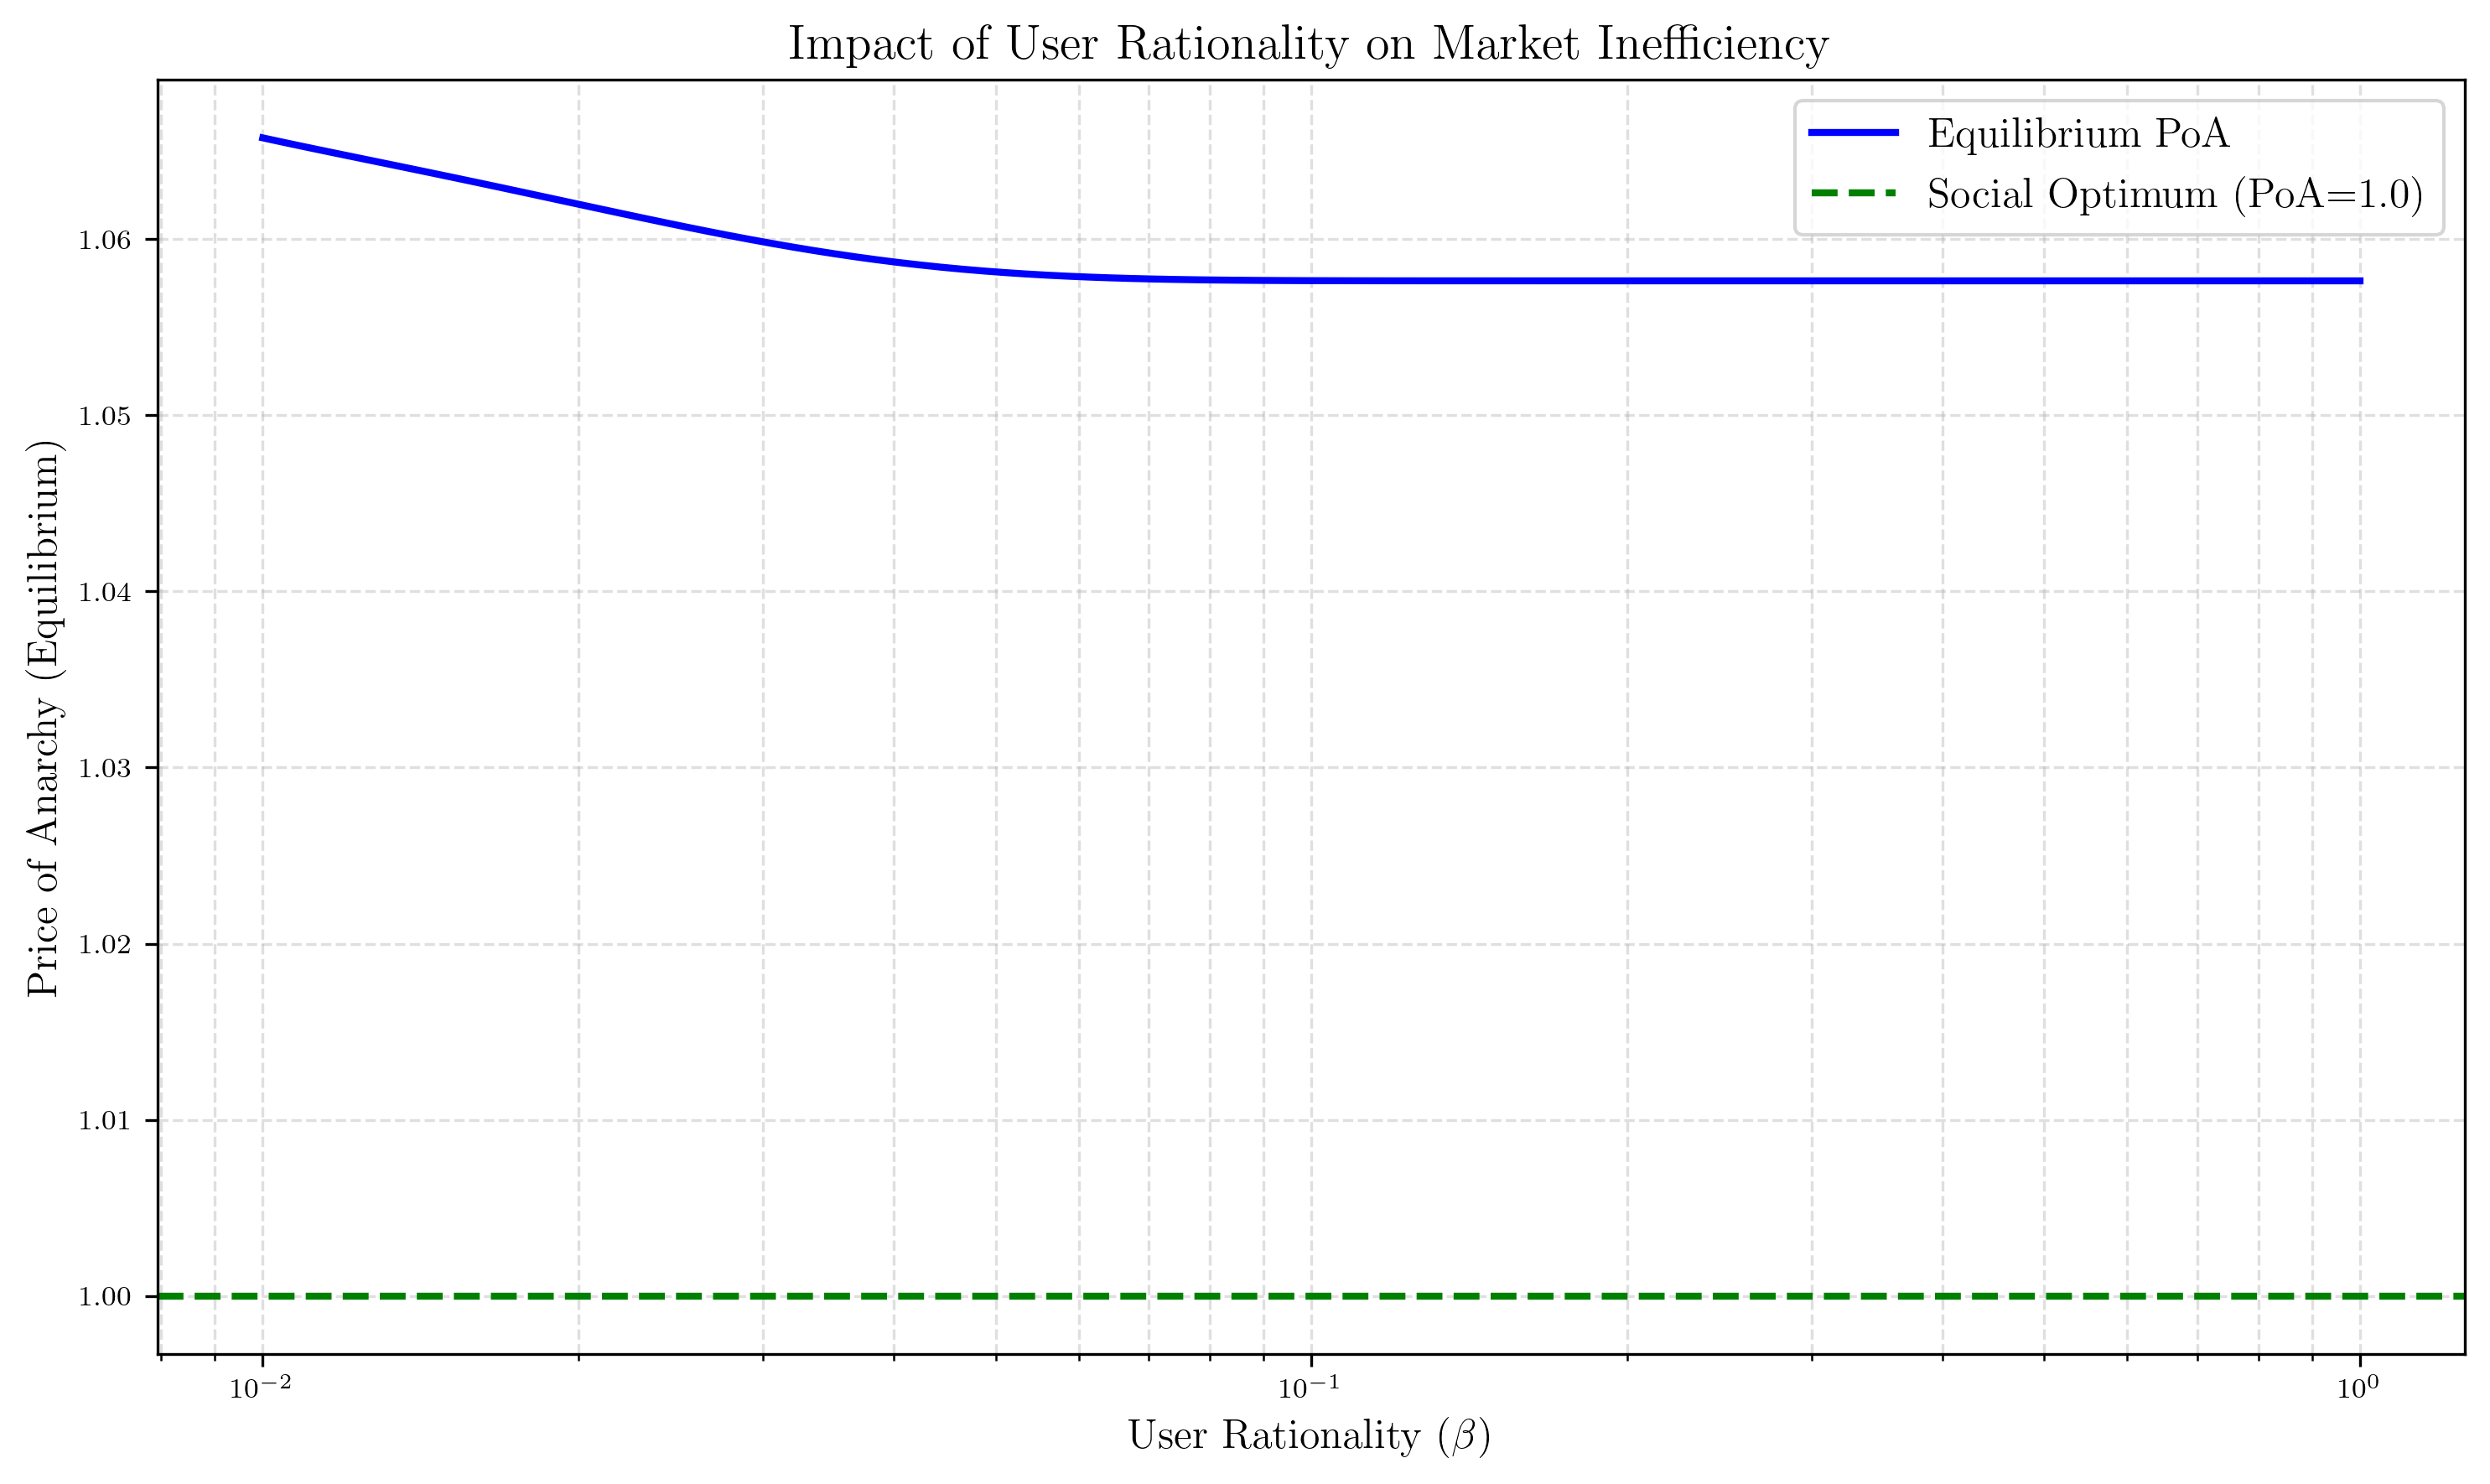

In [30]:
beta_values = np.logspace(-2, 0, num=100)
final_poas = sweep_beta_vs_poa(providers, config, beta_values)

plt.figure(figsize=(10, 6))
plt.plot(beta_values, final_poas, linestyle='-', linewidth=2, color='b', label='Equilibrium PoA')
plt.axhline(1.0, color='green', linestyle='--', linewidth=2, label='Social Optimum (PoA=1.0)')

plt.xscale('log') 
plt.xlabel(r'User Rationality ($\beta$)', fontsize=12)
plt.ylabel('Price of Anarchy (Equilibrium)', fontsize=12)
plt.title('Impact of User Rationality on Market Inefficiency', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()